In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from datetime import datetime, timedelta
import matplotlib.gridspec as gridspec
from matplotlib import animation, rc
import matplotlib.colors as colors
from IPython.display import HTML
import collections
import seaborn as sns
from collections import OrderedDict
from sklearn.neighbors import KDTree, BallTree
from sklearn.metrics import pairwise
from pandas.tseries.offsets import MonthEnd
import shapefile
from shapely.geometry import shape, Point, Polygon
import scipy.stats as stats
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pysal
import scipy.stats
from matplotlib.colors import LogNorm
from matplotlib.font_manager import FontProperties
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import cartopy.feature as feature
from zipfile import ZipFile
from lxml import html
import xml.etree.ElementTree as et
import h5py

Issues to resolve:
* figure out issue in malaysia

In [2]:
output_path = '/Users/danielfisher/Dropbox/working_documents/papers/globalgasflaring/figures/v2'

In [3]:
def get_arcmin(x):
    '''
    rounds the data decimal fraction of a degree
    to the nearest arc minute
    '''
    neg_values = x < 0

    abs_x = np.abs(x)
    floor_x = np.floor(abs_x)
    decile = abs_x - floor_x
    minute = np.around(decile * 60)  # round to nearest arcmin
    minute_fraction = minute*0.01  # convert to fractional value (ranges from 0 to 0.6)

    max_minute = minute_fraction > 0.59

    floor_x[neg_values] *= -1
    floor_x[neg_values] -= minute_fraction[neg_values]
    floor_x[~neg_values] += minute_fraction[~neg_values]
    
    # deal with edge cases, and just round them all up
    if np.sum(max_minute) > 0:
        floor_x[max_minute] = np.around(floor_x[max_minute])

    # now to get rid of rounding errors and allow comparison multiply by 100 and convert to int
    floor_x = (floor_x * 100).astype(int)

    return floor_x

# ------- OVERALL WORKFLOW ---------

1. Load in all datasets
2. Screen out overlapping data periods
3. Evaluate sampling information to check that it is consistent across the data.  
4. Adjust cloud cover statistics as they are not consistent across the sampling dataset.
5. 

# ------- DATA SETUP -------

Load in the hotspot dataframes for ATX and SLS: 

In [4]:
hotspot_path_ats = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/processed/l3/all_sensors/v2/all_flares_atx_adaptive.csv'
hotspot_path_sls = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/processed/l3/all_sensors/v2/all_flares_sls_adaptive.csv'

ats_hotspot_df = pd.read_csv(hotspot_path_ats)
sls_hotspot_df = pd.read_csv(hotspot_path_sls)

ats_hotspot_df['sample_counts_flare'] = 1
sls_hotspot_df['sample_counts_flare'] = 1


Load in the sampling dataframes for ATX and SLS:

In [5]:
# generate ATX sampling dataframe
path = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/processed/l3/all_sensors/v2/'
df_names = ['all_sampling_at1_adaptive.csv', 'all_sampling_at2_adaptive.csv', 'all_sampling_ats_adaptive.csv']

df_list = []
for df in df_names:
    df_list.append(pd.read_csv(os.path.join(path, df)))
ats_hotspot_sampling_df = pd.concat(df_list)               
ats_hotspot_sampling_df['sample_counts_all'] = 1
  

In [6]:
#sampling_path_ats = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/processed/l3/all_sensors/all_sampling_ats.csv'
sampling_path_sls = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/processed/l3/all_sensors/v2/all_sampling_sls_adaptive.csv'

#ats_hotspot_sampling_df = pd.read_csv(sampling_path_ats)
sls_hotspot_sampling_df = pd.read_csv(sampling_path_sls)

#ats_hotspot_sampling_df['sample_counts_all'] = 1
sls_hotspot_sampling_df['sample_counts_all'] = 1

Load in the volcano dataframe:

In [7]:
volc_path = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/external/volcanoes/volcanoes.csv'
volc_df = pd.read_csv(volc_path)
volc_df.dropna(inplace=True)

Generate the countries dataframe for the hotspot data.  Each unique hotspot location is assigned a country based on the EEZ land boundaries shape file.

In [8]:
def extract_countries():
    c_shp = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/external/borders/EEZ_land_union_v2_201410/EEZ_land_v2_201410.shp'
    shape_file = shapefile.Reader(c_shp)
    #first feature of the shapefile
    countries = {}
    for feature in shape_file.shapeRecords():
        country_name = feature.record[2]
        country_shp = shape(feature.shape.__geo_interface__)
        #eez_boundaries[eez_name] = eez_shp.simplify(0.2) 
        countries[country_name] = country_shp
    return countries
    
    
def create_countries_dataframe(countries, df):
    cols = ['lats_arcmin', 'lons_arcmin', 'lats', 'lons']
    countries_df = df.drop_duplicates(['lats_arcmin', 'lons_arcmin'])[cols].copy()
    country_list = []
    for i, row in countries_df.iterrows():
        country_found = False
        point = Point(row.lons,row.lats)    
        for k in countries:
            poly = countries[k]
            if point.within(poly):
                country_list.append(k)
                country_found = True
                break
        if country_found:
            continue    
        # if we are here no countries have been found so
        country_list.append('Without Country')  
    countries_df['countries'] = country_list
    return countries_df
    
countries_dict = extract_countries()
ats_countries_df = create_countries_dataframe(countries_dict, ats_hotspot_df)
sls_countries_df = create_countries_dataframe(countries_dict, sls_hotspot_df)

Load in the BCM data from DMSP for comparison against ATSR dataset:

In [9]:
bcm_path = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/external/dmsp/BCM_Global_20110223.xlsx'
cols=['Location', 'Year', 'MEAN BCM']
bcm_df_dict = pd.read_excel(bcm_path,  sheetname=None)
bcm_df = pd.concat(bcm_df_dict).reset_index()[['Year', 'Location', 'MEAN BCM']]
bcm_df.loc[bcm_df.Location=='Russia_Combined', 'Location'] = 'Russia'
bcm_df.loc[bcm_df.Location=='USA_Combined', 'Location'] = 'USA'
bcm_df.rename(columns={'Location': 'countries', 'Year': 'year', 'MEAN BCM': 'bcm'}, inplace=True)

Load in the VIIRS hotspot data for Iraq for comparison against ATSR:

In [10]:
viirs_iraq_hotspot_path = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/external/viirs_iraq_flares/hotspots.xlsx'
viirs_iraq_hotspot_df = pd.read_excel(viirs_iraq_hotspot_path)
viirs_iraq_hotspot_df.rename(columns={'lat': 'lats', 'lon': 'lons'}, inplace=True)

Load in VIIRS hotspot data for bias assessment of SLSTR:

In [443]:
viirs_bias_hotspot_path = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/external/slstr_bias_assessment'

viirs_got_hotspot_df = pd.read_csv(os.path.join(viirs_bias_hotspot_path, 'got.csv'))
viirs_got_hotspot_df.rename(columns={'lat': 'lats', 'lon': 'lons'}, inplace=True)

viirs_libya_hotspot_df = pd.read_csv(os.path.join(viirs_bias_hotspot_path, 'libya.csv'))
viirs_libya_hotspot_df.rename(columns={'lat': 'lats', 'lon': 'lons'}, inplace=True)

viirs_niger_delta_hotspot_df = pd.read_csv(os.path.join(viirs_bias_hotspot_path, 'niger_delta.csv'))
viirs_niger_delta_hotspot_df.rename(columns={'lat': 'lats', 'lon': 'lons'}, inplace=True)

Load in the VIIRS industrial flaring activity for comparison against ATSR:

In [11]:
viirs_industrial_path = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/external/viirs_industrial_sites'
kmz_fname = 'doc.kml'
doc = et.parse(os.path.join(viirs_industrial_path, kmz_fname))

In [12]:
nmsp = '{http://www.opengis.net/kml/2.2}'

df_list = []
for pm in doc.iterfind('.//{0}Placemark'.format(nmsp)):

    name = (pm.find('{0}name'.format(nmsp)).text)
    for ls in pm.iterfind('.//{0}coordinates'.format(nmsp)):
        pos = np.fromstring(ls.text.strip().replace('\n',''), dtype=float, sep=', ') 
        lon = pos[0]
        lat = pos[1]        
        df = pd.DataFrame([[lat,lon,name]], columns=['lats', 'lons', 'Name'])
        df_list.append(df)
        break
viirs_industrial_df = pd.concat(df_list)

viirs_industrial_df['lats_arcmin'] = get_arcmin(viirs_industrial_df.lats.values)
viirs_industrial_df['lons_arcmin'] = get_arcmin(viirs_industrial_df.lons.values)

id_dict = {'Nonmetal-mineral':1,
           'Ferrous-metal': 2,
           'Coal-processing': 3,
           'Oil/gas': 4
          }
viirs_industrial_df['name_id'] = viirs_industrial_df.Name.map(id_dict)

In [13]:
viirs_countries_df = create_countries_dataframe(countries_dict, viirs_industrial_df)

Load in NightFire data for comparison against SLSTR:

In [14]:
nightfire_path = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/external/viirs_nightfire'

df_list = []
for f in os.listdir(nightfire_path):
    df_list.append(pd.read_csv(os.path.join(nightfire_path, f)))
nightfire_df = pd.concat(df_list)

nightfire_df.rename(columns={'Lat_GMTCO': 'lats', 'Lon_GMTCO': 'lons'}, inplace=True)
nightfire_df['lats_arcmin'] = get_arcmin(nightfire_df.lats.values)
nightfire_df['lons_arcmin'] = get_arcmin(nightfire_df.lons.values)

In [15]:
nightfire_countries_df = create_countries_dataframe(countries_dict, nightfire_df)

In [16]:
def load_viirs_zenith():
    path = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/external/viirs_zenith/'
    f = 'GMODO-SVM01-SVM03-SVM04-SVM05_npp_d20150705_t0254234_e0255476_b19092_c20171108213818198685_noaa_ops.h5'
    ds = h5py.File(os.path.join(path, f))  
    vza = ds['All_Data']['VIIRS-MOD-GEO_All']['SatelliteZenithAngle'][:]
    return vza[0,:]

viirs_zenith_angles = load_viirs_zenith()

# ------- DATA SELECTION -------

## Drop sensor overlap data (also see Notes at bottom)

Some of the ATX sensors have various issues during there operational lifetimes (see the notes about this at the bottom).  It therefore makes sense to prioritse data from a certain sensor over another given any overlapping periods.  Overlaps are removed from the persistent hotspot and sampling dataframes below before any further analysis is performed on the data.  The justifications for the sensors prioritisation in any overlapping period are given at the bottom of the notebook.  In some instances, there is still poor sensor operational behaviour, but if no overlapping data is available we have to use what is given to us.  The masking is only applied to the ATX data, not SLSTR:

In [17]:
# persistent hotspot df

mask = (~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 1995)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2003)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 1)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 2)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 3)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 4)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 5)) &
        ~((ats_hotspot_df.sensor == 'at1' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 7)) &
        ~((ats_hotspot_df.sensor == 'at1' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 8)) &
        ~((ats_hotspot_df.sensor == 'at1' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 9)) &
        ~((ats_hotspot_df.sensor == 'at1' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 10)) &
        ~((ats_hotspot_df.sensor == 'at1' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 11)) &
        ~((ats_hotspot_df.sensor == 'at1' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 12)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2002) & (ats_hotspot_df.month == 4)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2002) & (ats_hotspot_df.month == 5)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2002) & (ats_hotspot_df.month == 6)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2002) & (ats_hotspot_df.month == 7)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2002) & (ats_hotspot_df.month == 8)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2002) & (ats_hotspot_df.month == 9)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2002) & (ats_hotspot_df.month == 10)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2002) & (ats_hotspot_df.month == 11)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2002) & (ats_hotspot_df.month == 12))        
       )

ats_hotspot_df = ats_hotspot_df[mask]

In [18]:
print ats_hotspot_df.drop_duplicates(['lats_arcmin', 'lons_arcmin']).shape[0]

40914


In [19]:
# all sampling dataframe

mask = (~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 1995)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2003)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 1)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 2)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 3)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 4)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 5)) &
        ~((ats_hotspot_sampling_df.sensor == 'at1' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 7)) &
        ~((ats_hotspot_sampling_df.sensor == 'at1' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 8)) &
        ~((ats_hotspot_sampling_df.sensor == 'at1' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 9)) &
        ~((ats_hotspot_sampling_df.sensor == 'at1' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 10)) &
        ~((ats_hotspot_sampling_df.sensor == 'at1' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 11)) &
        ~((ats_hotspot_sampling_df.sensor == 'at1' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 12)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2002) & (ats_hotspot_sampling_df.month == 4)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2002) & (ats_hotspot_sampling_df.month == 5)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2002) & (ats_hotspot_sampling_df.month == 6)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2002) & (ats_hotspot_sampling_df.month == 7)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2002) & (ats_hotspot_sampling_df.month == 8)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2002) & (ats_hotspot_sampling_df.month == 9)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2002) & (ats_hotspot_sampling_df.month == 10)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2002) & (ats_hotspot_sampling_df.month == 11)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2002) & (ats_hotspot_sampling_df.month == 12))        
       )

ats_hotspot_sampling_df = ats_hotspot_sampling_df[mask]


In [20]:
sls_hotspot_df_0317 = sls_hotspot_df[(sls_hotspot_df.year == 2017) & (sls_hotspot_df.month == 3)]

mask = ((sls_hotspot_df.year != 2016) & ~((sls_hotspot_df.year == 2017) & 
                                                   (sls_hotspot_df.month <= 4)))
sls_hotspot_df = sls_hotspot_df[mask]

In [21]:
print sls_hotspot_df.drop_duplicates(['lats_arcmin', 'lons_arcmin']).shape[0]

22962


In [22]:
mask = ((sls_hotspot_sampling_df.year != 2016) & ~((sls_hotspot_sampling_df.year == 2017) & 
                                                   (sls_hotspot_sampling_df.month <= 4)))
sls_hotspot_sampling_df = sls_hotspot_sampling_df[mask]


# ------- FLARE ACTIVITIY DISCRIMINATION -------

* Various approaches are applied in this section to discriminate between flaring and non-flaring persistent hotspots.  First the spectral ratio method is applied to the ATX and SLS datasets.  In the case of ATX all data with either invalid backgrounds, saturated MWIR radianes (are already NaN), or orberved by AT1 have the MWIR radiance value set to NaN.  The ratio is then computed between the SWIR and MWIR spectral radiances (with the NaN being preserved through this ratio).  For each thermal anomaly grid cell the median of all ratio values is then computed across the entire time series for the grid cell, if this median value is found to be between the assumed flaring thresholds then it is set to be a flare.

* In the case of SLSTR, no data is excluded prior to the calculation of the median, and no upper threshold is used.

* Any AT1 data that has associated AT2 and ATS data with its grid cell now has a flaring acitivity classification from the application of the spectral ratio method.  However, some grid cells are only associated with AT1 falres and therefore have no valid classification.  In such instances, the AT1 data is assigned a classficiation based on a majority voting looking at all grid cells within 1 deg over the entire time series, working on the assumption that flaring activity is clustered over certain spatial scales. 
* In some cases AT2 and ATS data also have no valid ratio values.  If that invalid ratio is caused by having no background observations, then the AT2 or ATS grid cell is assigned to that of its neighbours.  However, if it is caused by MWIR saturation, then it is assumed to be not associated with gas flaring.

## Extract ATX Ratios

In [23]:
ats_ratio_df = ats_hotspot_df[['mwir_bg', 'sensor', 'swir_radiances', 'mwir_radiances',
                             'lats_arcmin', 'lons_arcmin', 'lats', 'lons', 'sample_counts_flare']].copy()

ats_ratio_df['mwir_saturated_counts'] = ats_ratio_df.mwir_radiances.isnull()
ats_ratio_df['mwir_no_bg_counts'] = ats_ratio_df.mwir_bg == -1

ats_ratio_df.mwir_bg.loc[ats_ratio_df.mwir_bg == -1] = np.nan  # invalid background
ats_ratio_df.mwir_bg.loc[ats_ratio_df.sensor == 'at1'] = np.nan  # no MWIR from AT1


eps= 0.001
ratio = ats_ratio_df.swir_radiances.values / \
        ((ats_ratio_df.mwir_radiances.values - ats_ratio_df.mwir_bg.values)+ eps)
ats_ratio_df['ratio'] = ratio

to_group = ['lats_arcmin', 'lons_arcmin']
to_agg = {'ratio': np.nanmedian,
          'lats': np.mean,
          'lons': np.mean,
          'sample_counts_flare': np.sum,
          'mwir_saturated_counts': np.sum,
          'mwir_no_bg_counts': np.sum}
ats_ratio_df = ats_ratio_df.groupby(to_group, as_index=False).agg(to_agg)

ats_ratio_df['is_flare'] = (ats_ratio_df.ratio >= 1.61) & (ats_ratio_df.ratio < 8.35)

/Users/danielfisher/anaconda2/envs/kcl-globalgasflaring/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/danielfisher/anaconda2/envs/kcl-globalgasflaring/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:612: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


## Pre-reassingment ATS Stats

In [24]:
flaring_map = ats_ratio_df[ats_ratio_df.is_flare.astype('bool')][['lats_arcmin', 'lons_arcmin']]
non_flaring_map = ats_ratio_df[~ats_ratio_df.is_flare.astype('bool') & ats_ratio_df.ratio.notnull()][['lats_arcmin', 'lons_arcmin']]
null_map = ats_ratio_df[~ats_ratio_df.is_flare.astype('bool') & ats_ratio_df.ratio.isnull()][['lats_arcmin', 'lons_arcmin']]

In [25]:
for l, m in zip(['flares', 'not_flares', 'null'], [flaring_map, non_flaring_map, null_map]):
    sub_df =  ats_hotspot_df.merge(m, on=['lats_arcmin', 'lons_arcmin'])
    print 'AT1', l, sub_df[sub_df.sensor == 'at1'].groupby(['lats_arcmin', 'lons_arcmin']).agg({'sample_counts_flare': np.sum}).shape[0]
    print 'AT2', l, sub_df[sub_df.sensor == 'at2'].groupby(['lats_arcmin', 'lons_arcmin']).agg({'sample_counts_flare': np.sum}).shape[0]
    print 'ATS', l, sub_df[sub_df.sensor == 'ats'].groupby(['lats_arcmin', 'lons_arcmin']).agg({'sample_counts_flare': np.sum}).shape[0]

    print 


AT1 flares 13187
AT2 flares 19754
ATS flares 21582

AT1 not_flares 6082
AT2 not_flares 9948
ATS not_flares 10279

AT1 null 2091
AT2 null 2851
ATS null 1670



## Extract SLS Ratio

In [26]:
sls_ratio_df = sls_hotspot_df[['sensor', 'swir_radiances', 'swir_radiances_22',
                       'lats_arcmin', 'lons_arcmin', 'lats', 'lons', 'sample_counts_flare']].copy()

eps= 0.001
ratio = sls_ratio_df.swir_radiances.values / (sls_ratio_df.swir_radiances_22 + eps)
sls_ratio_df['ratio'] = ratio

# here taking the mean behaviour of the gas flare over all its samples.
# This is where something is going wrong with the SLSTR behaviour.
# so maybe we have some bad data in here somewhere.
to_group = ['lats_arcmin', 'lons_arcmin']
to_agg = {'ratio': np.nanmedian,
          'lats': np.mean,
          'lons': np.mean,
          'sample_counts_flare': np.sum}
sls_ratio_df = sls_ratio_df.groupby(to_group, as_index=False).agg(to_agg)

# inser flare variable
sls_ratio_df['is_flare'] = (sls_ratio_df.ratio >= 0.94) & (sls_ratio_df.ratio < 1.92)

In [27]:
print 'SLS is flare', sls_ratio_df['is_flare'].sum()
print 'SLS not flare', (~sls_ratio_df['is_flare']).sum()


SLS is flare 11266
SLS not flare 11696


## Spectral Ratio and Threshold Selection Plot

/Users/danielfisher/anaconda2/envs/kcl-globalgasflaring/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in divide
  # This is added back by InteractiveShellApp.init_path()
/Users/danielfisher/anaconda2/envs/kcl-globalgasflaring/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/Users/danielfisher/anaconda2/envs/kcl-globalgasflaring/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in divide
/Users/danielfisher/anaconda2/envs/kcl-globalgasflaring/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in divide


MWIR ratio 1400K 1.61698268645
MWIR ratio 2800K 8.34675318512
SWIR ratio 1400K 0.844738420688
SWIR ratio 2800K 1.92537559432


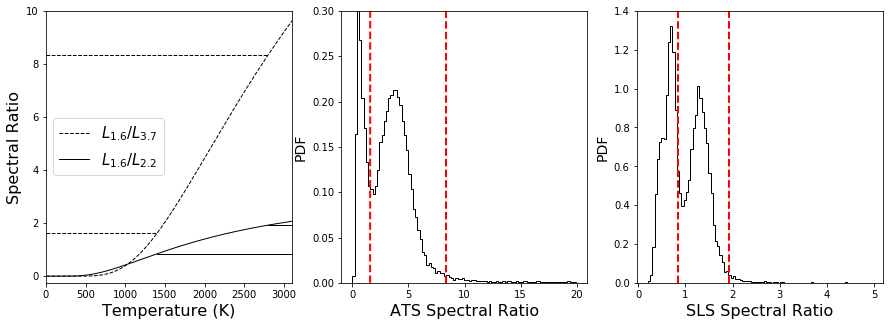

In [28]:
plt.close('all')

def planck_radiance(wvl, temp):
    '''
    wvl: wavelngth (microns)
    temp: temperature (kelvin)
    '''
    c1 = 1.19e-16  # W m-2 sr-1
    c2 = 1.44e-2  # mK
    wt = (wvl*1.e-6) * temp # m K
    d = (wvl*1.e-6)**5 * (np.exp(c2/wt)-1)
    return c1 / d * 1.e-6  # W m-2 sr-1 um-1

# set up fig
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# spectral ratio plot
flare_size = 10000  # in sq. m.
pixel_size = 1e6  # in sq. m.
flare_area_pc = flare_size / pixel_size  # unitless
temps = np.arange(0,3501, 1)  # in K

spect_rad_swir = flare_area_pc * planck_radiance(1.6, temps)
spect_rad_swir_2 = flare_area_pc * planck_radiance(2.2, temps)
spect_rad_mwir = flare_area_pc * planck_radiance(3.7, temps)
spect_rad_lwir = flare_area_pc * planck_radiance(11, temps)

ratio_mwir = spect_rad_swir / spect_rad_mwir
ratio_swir = spect_rad_swir / spect_rad_swir_2

print 'MWIR ratio 1400K', ratio_mwir[1400]
print 'MWIR ratio 2800K', ratio_mwir[2800]
print 'SWIR ratio 1400K', ratio_swir[1400]
print 'SWIR ratio 2800K', ratio_swir[2800]


ax0.plot(temps, ratio_mwir,  "k--", linewidth=1, label="$L_{1.6} / L_{3.7}$")
ax0.plot([-1,1400],[ratio_mwir[1400], ratio_mwir[1400]],'k--',linewidth=1)
ax0.plot([-1,2800],[ratio_mwir[2800], ratio_mwir[2800]],'k--',linewidth=1)

ax0.set_ylim([-0.25,10])
ax0.set_xlim([-0.25,3100])

ax0.plot(temps, ratio_swir,  "k-", linewidth=1, label="$L_{1.6} / L_{2.2}$")
ax0.plot([1400,3501],[ratio_swir[1400], ratio_swir[1400]],'k-',linewidth=1)
ax0.plot([2800,3501],[ratio_swir[2800], ratio_swir[2800]],'k-',linewidth=1)
ax0.legend(prop={'size': 15})

ax0.set_xlabel("Temperature (K)", fontsize=16)
ax0.set_ylabel("Spectral Ratio", fontsize=16)

# histogram plots
ax1.hist(ats_ratio_df.ratio[(ats_ratio_df.ratio > 0) & (ats_ratio_df.ratio < 20)], 
         bins=100, normed=True, histtype='step', color='k')
ax1.plot([1.6,1.61], [0,0.4], 'r--', linewidth=2)
ax1.plot([8.34,8.34], [0,0.4], 'r--', linewidth=2)
ax1.set_ylim([0, 0.3])
ax1.set_xlabel('ATS Spectral Ratio', fontsize=16)
ax1.set_ylabel('PDF', fontsize=14)


ax2.hist(sls_ratio_df.ratio[(sls_ratio_df.ratio > 0) & (sls_ratio_df.ratio < 5)], 
         bins=100, normed=True, histtype='step', color='k')
ax2.plot([0.85,0.85], [0,1.5], 'r--', linewidth=2)
ax2.plot([1.92,1.92], [0,1.5], 'r--', linewidth=2)
ax2.set_xlabel('SLS Spectral Ratio', fontsize=16)
ax2.set_ylabel('PDF', fontsize=14)

ax2.set_ylim([0, 1.4])

plt.savefig(os.path.join(output_path, 'ratio_plot.png'), bbox_inches='tight', dpi=600)
plt.show()


## Reassign null flares based on majority vote

In some cases, we wish to reassign points will null ratios to the flaring class.  As currently, if the ratio is invalid then we assume that the point is not a flare, and that may not be the case.  In all cases if the ratio is invlaid then the classification of the flares is that of its neighbours.  

For AT1 all persistent hotspots have no ratios associated with them.  In those instances where ATS and AT2 data are avilable in a grid cell then, assuming ATS and AT2 ratios are avilable, the grid cell can still have a valid ratio assigned.  However, not all AT1 grid cells have ATS and AT2 data associated with them.  IN such cases the assigment is made from the nearest neighbours.

For AT2 and ATS if the a grid cell has no valid ratio values then we also assign the ratio from nearby grid cells.  The causes of no valid ratios for these sesors are either, no suitable background radiance estimate or a saturated MWIR channel.  Less often sampled gas flares may suffer from no valid background, and larger more extreme flares may result in saturation of the MWIR channel.  So we assign class based on the local neighbourhood.   

In [29]:
def reassign_flares(ratio_df, k=1000, d=1):
    '''
    k = number of neighbors to consider
    d = max distance to consider for neighbours
    '''
    current_flares = ratio_df.is_flare.values

    flare_locations = np.array(zip(np.deg2rad(ratio_df.lats.values), 
                                   np.deg2rad(ratio_df.lons.values)))

    # compare the flare locations to the potential locations in the orbit
    locations_balltree = BallTree(flare_locations, metric='haversine')
    distances, indexes = locations_balltree.query(flare_locations, k=k) 

    # distances mask
    self_mask = np.rad2deg(distances) > 1/60  # do not consider the point itself
    masked_distances = (np.rad2deg(distances) < d) & self_mask # and not pionts > 1 deg away

    # update is flare based on neighbours
    is_flare = np.ones(ratio_df.ratio.shape)*999
    for i in xrange(is_flare.size):

        # get the ratio of the set of flares a closest to current flare 
        closest_flares = ratio_df.is_flare[indexes[i,:]] 

        # mask based on distances
        masked_closest = closest_flares[masked_distances[i, :]]
        if len(masked_closest) > 0:

            # take the nanmean of valid values.  We will have nans nearby
            # due to invalid backgrounds and observations from AT1
            mean_local_type = np.nanmean(masked_closest)

            # if mean is > 0.5, then majority is flare, else majority is industrial
            if mean_local_type >= 0.5:
                is_flare[i] = 1
            else:
                is_flare[i] = 0
        else:
            is_flare[i] = current_flares[i]
    
    # get the null ratio mask
    ratio_df['updated_flare'] = is_flare
    return ratio_df

In [30]:
ats_ratio_df = reassign_flares(ats_ratio_df, d=1)

In [31]:
mask = ats_ratio_df.ratio.isnull()
ats_ratio_df.is_flare.loc[mask] = ats_ratio_df.updated_flare.loc[mask]

## post assignment ATSR stats

In [32]:
flaring_map = ats_ratio_df[ats_ratio_df.is_flare.astype('bool')][['lats_arcmin', 'lons_arcmin']]
non_flaring_map = ats_ratio_df[~ats_ratio_df.is_flare.astype('bool')][['lats_arcmin', 'lons_arcmin']]

In [33]:
for l, m in zip(['flares', 'not_flares'], [flaring_map, non_flaring_map]):
    sub_df =  ats_hotspot_df.merge(m, on=['lats_arcmin', 'lons_arcmin'])
    print 'AT1', l, sub_df[sub_df.sensor == 'at1'].groupby(['lats_arcmin', 'lons_arcmin']).agg({'sample_counts_flare': np.sum}).shape[0]
    print 'AT2', l, sub_df[sub_df.sensor == 'at2'].groupby(['lats_arcmin', 'lons_arcmin']).agg({'sample_counts_flare': np.sum}).shape[0]
    print 'ATS', l, sub_df[sub_df.sensor == 'ats'].groupby(['lats_arcmin', 'lons_arcmin']).agg({'sample_counts_flare': np.sum}).shape[0]

    print 

AT1 flares 14426
AT2 flares 21186
ATS flares 22553

AT1 not_flares 6934
AT2 not_flares 11367
ATS not_flares 10978



## Screen Volcanoes

As there is overlap between flaring and non-flaring thermal anomalies, further screening of the dataset is beneficial.  This is particularly the case for volcanoes, which if detected can produce very large signals that are not representative of true flaring activity.  Here we screen any data points that are within 10 km of a volcano that has been seen active at any point.

In [34]:
def dist_to_nearest_volcano(volc_df, ratio_df):
    
    volc_lat_lon = np.dstack([np.deg2rad(volc_df.Latitude.values), 
                              np.deg2rad(volc_df.Longitude.values)])[0]
    volc_balltree = BallTree(volc_lat_lon, metric='haversine')

    # get the unique flare lats and lons for assessment in kdtree
    flare_locations = np.array(zip(np.deg2rad(ratio_df.lats.values), 
                                   np.deg2rad(ratio_df.lons.values)))

    # compare the flare locations to the potential locations in the orbit
    distances, indexes = volc_balltree.query(flare_locations, k=1) 

    # set up the dataframe to hold the distances
    degree_distances = np.rad2deg(distances)
    mask = degree_distances < 5.0/60  # if within ~10km of any volcano, then is volcano
    ratio_df['is_volcano'] = mask
    return ratio_df

In [35]:
ats_ratio_df = dist_to_nearest_volcano(volc_df, ats_ratio_df)
sls_ratio_df = dist_to_nearest_volcano(volc_df, sls_ratio_df)

In [36]:
# we want to know how many more points are exluded by volcanoes, on top of the points already excluded
# by the ratio test, so where the ratio is good!
ats_volcano_map = ats_ratio_df[ats_ratio_df.is_volcano.astype('bool') & 
                               ats_ratio_df.is_flare][['lats_arcmin', 'lons_arcmin']]
sls_volcano_map = sls_ratio_df[sls_ratio_df.is_volcano.astype('bool') & 
                               sls_ratio_df.is_flare][['lats_arcmin', 'lons_arcmin']]


In [37]:
ats_ratio_df.is_flare.loc[ats_ratio_df.is_volcano] = 0
sls_ratio_df.is_flare.loc[sls_ratio_df.is_volcano] = 0

In [38]:
sub_df =  ats_hotspot_df.merge(ats_volcano_map, on=['lats_arcmin', 'lons_arcmin'])
print 'AT1', 'Volcanoes', sub_df[sub_df.sensor == 'at1'].groupby(['lats_arcmin', 'lons_arcmin']).agg({'sample_counts_flare': np.sum}).shape[0]
print 'AT2', 'Volcanoes', sub_df[sub_df.sensor == 'at2'].groupby(['lats_arcmin', 'lons_arcmin']).agg({'sample_counts_flare': np.sum}).shape[0]
print 'ATS', 'Volcanoes', sub_df[sub_df.sensor == 'ats'].groupby(['lats_arcmin', 'lons_arcmin']).agg({'sample_counts_flare': np.sum}).shape[0]

print 

sub_df =  sls_hotspot_df.merge(sls_volcano_map, on=['lats_arcmin', 'lons_arcmin'])
print 'SLSTR', 'Volcanoes', sub_df[sub_df.sensor == 'sls'].groupby(['lats_arcmin', 'lons_arcmin']).agg({'sample_counts_flare': np.sum}).shape[0]


AT1 Volcanoes 33
AT2 Volcanoes 64
ATS Volcanoes 66

SLSTR Volcanoes 4


## Thermal Anomaly Plotting

In [39]:
def plot_data_screening(ratio_df, lab, fname, leg=True):
    
    flare_df = ratio_df[ratio_df.is_flare.astype('bool')]
    not_flare_df = ratio_df[~ratio_df.is_flare.astype('bool')]
    volc_df = ratio_df[ratio_df.is_volcano]
    
    plt.close('all')
    fig = plt.figure(figsize=(15,10))
    ax_list = []
    ax_list.append(plt.subplot2grid((4, 5), (0, 0), colspan=5, rowspan=3, projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 0), projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 1), projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 2), projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 3), projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 4), projection=ccrs.PlateCarree()))
    
    for ax in ax_list:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # set limites
    xlims = [(-180, 180), (-105, -87), (4, 9), (46, 56), (65, 82), (106, 125)]
    ylims = [(-90, 90), (25, 39), (3, 7), (23, 33), (55, 68), (33, 45)]
    pos = [(-102, 40), (-2, -1), (39, 26), (83, 62), (113, 47)]
    for ax, xlim, ylim in zip(ax_list, xlims, ylims):
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.coastlines()
        
    # scale the values
    flare_counts = flare_df['sample_counts_flare']     
    ind_counts = ratio_df['sample_counts_flare']
    
    # make main plot
    ax_list[0].text(0.94, 0.92, lab, transform=ax_list[0].transAxes, fontsize=25)
    ax_list[0].plot(volc_df.lons, volc_df.lats, '.', color='gray', markersize=10, label='Volcanic')
    scat = ax_list[0].scatter(flare_df.lons, flare_df.lats,
                      s=flare_counts/10, lw=0.2, 
                      edgecolors='r',
                      facecolor='None',
                      label = 'Flare')
    scat = ax_list[0].scatter(not_flare_df.lons, not_flare_df.lats,
                      s=ind_counts/10, lw=0.2, 
                      edgecolors='b',
                      facecolor='None',
                      label = "Non-Flare")
    leg0 = ax_list[0].legend(loc = 2, scatterpoints = 1, prop={'size': 13})
    leg0.legendHandles[0]._sizes = [100]
    leg0.legendHandles[1]._sizes = [100]
    leg0.legendHandles[2]._sizes = [100]
    leg0.get_frame().set_alpha(1)
    
    if leg:
        l1 = ax_list[0].scatter([-170],[-70], s=10/10, edgecolors='k', facecolor='None')
        l2 = ax_list[0].scatter([-170],[-70], s=100/10, edgecolors='k', facecolor='None')
        l3 = ax_list[0].scatter([-170],[-70], s=500/10, edgecolors='k', facecolor='None')
        l4 = ax_list[0].scatter([-170],[-70], s=1000/10, edgecolors='k', facecolor='None')

        labels = ["10", "100", "500", "1000"]
        leg1 = ax_list[0].legend([l1, l2, l3, l4], labels, frameon=True, fontsize=14,
                         handlelength=2, loc = 3, borderpad = 1,
                         handletextpad=1, title='N. Samples', scatterpoints = 1, prop={'size': 15})
        leg1.get_frame().set_alpha(1)
        ax_list[0].add_artist(leg0)
    
    # add roi boxes
    for i, (p, x, y) in enumerate(zip(pos, xlims[1:], ylims[1:])):
        ax_list[0].plot([x[0], x[0], x[1], x[1], x[0]], 
                        [y[0], y[1], y[1], y[0], y[0]], 'k-')
        ax_list[0].text(p[0], p[1], str(i+1)+'.', fontsize=12)
        
    # make alt plots
    for i, ax in enumerate(ax_list[1:]):        
        scat = ax.scatter(flare_df.lons, flare_df.lats,
                          s=flare_counts/10, lw=0.2, 
                          edgecolors='r',
                          facecolor='None')
        scat = ax.scatter(not_flare_df.lons, not_flare_df.lats,
                          s=ind_counts/10, lw=0.2, 
                          edgecolors='b',
                          facecolor='None')
        ax.text(0.1, 0.1, str(i+1)+'.', transform=ax.transAxes, fontsize=15)
    
    plt.savefig(os.path.join(output_path, fname), bbox_inches='tight', dpi=600)
    plt.show()

No handlers could be found for logger "shapely.geos"


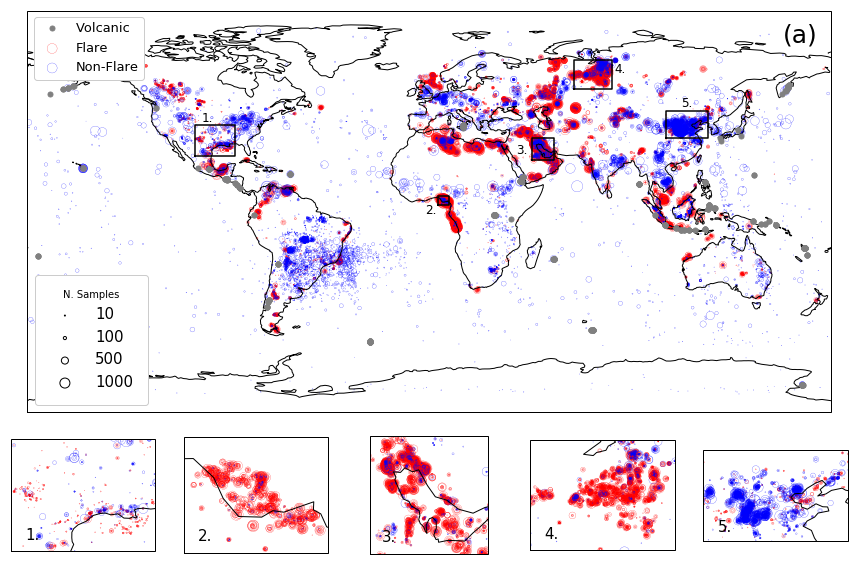

In [40]:
plot_data_screening(ats_ratio_df, '(a)', 'atsr_hotspots.png')

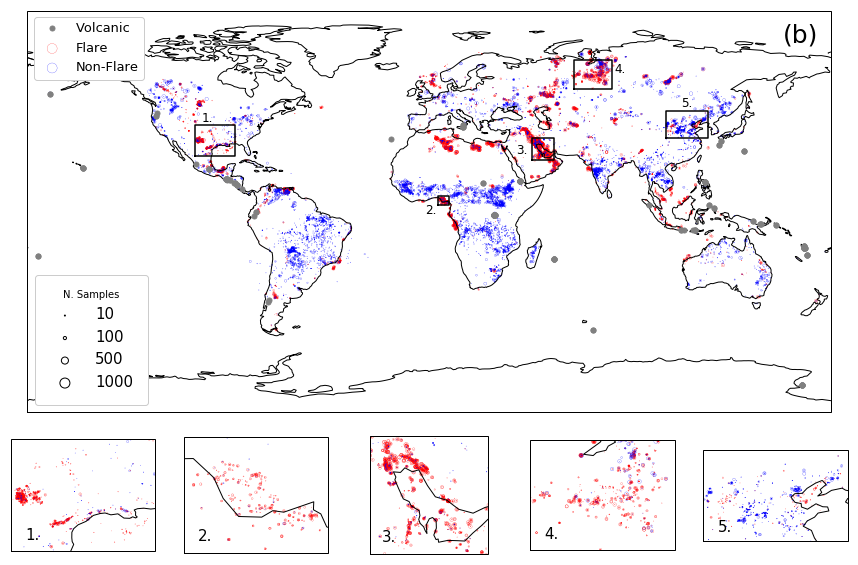

In [41]:
plot_data_screening(sls_ratio_df, '(b)', 'slstr_hotspots.png')

# ------- CREATE FLARING DATASET -------

In [42]:
ats_flaring_map = ats_ratio_df[ats_ratio_df.is_flare.astype('bool')][['lats_arcmin', 'lons_arcmin']]
sls_flaring_map = sls_ratio_df[sls_ratio_df.is_flare.astype('bool')][['lats_arcmin', 'lons_arcmin']]

In [43]:
ats_flare_sampling_df = ats_hotspot_sampling_df.merge(ats_flaring_map, on=['lats_arcmin', 'lons_arcmin'])
sls_flare_sampling_df = sls_hotspot_sampling_df.merge(sls_flaring_map, on=['lats_arcmin', 'lons_arcmin'])

In [44]:
ats_flare_df = ats_hotspot_df.merge(ats_flaring_map, on=['lats_arcmin', 'lons_arcmin'])
sls_flare_df = sls_hotspot_df.merge(sls_flaring_map, on=['lats_arcmin', 'lons_arcmin'])

In [424]:
# set up the slstr annum dataset used in some of the analyses
sls_flare_df_annum = sls_flare_df[((sls_flare_df.year == 2017) & (sls_flare_df.month >= 5)) | (sls_flare_df.year == 2018)]
sls_flare_sampling_df_annum = sls_flare_sampling_df[((sls_flare_sampling_df.year == 2017) & (sls_flare_sampling_df.month >= 5)) | (sls_flare_sampling_df.year == 2018)]

# ------- FLARE SCREENING -------

There is irregular behaviour in the AT1 hotspot data in the Northern Hemisphere in some years - for evidence of this see the gif below.  During 1994 and 1995 there are odd high FRP detections over much of the northern hemisphere, this leads to erroneoously high FRPs being reported for the US, UK, Canada and Russia.  These values need to be exluded.  Below first examining the statistics of the dataset it is clear that the tails of the AT1 statistical distributions have much higher values than that of ATS.  Looking at the maximum mean values for any individual ATS gas flare we can see that the maximum mean value is around 80 MW.  Whilst for AT1 these maximum mean values go up to 670 MW.  Looking at the distribution of the standard deviation, the AT1 and and ATS data have similar ranges, but a larger proportion of the AT1 data is located in the tail.  For ATS over *** % of the data has standard deviation values that are less than *** and using this information we can threshold the AT1 data so that the flaring activity is consistent with that seen on ATS.  We can also apply the same approach to AT2 to remove any flaring activity that is not consistent with ATS.   

By setting an upper limit on the standard deviation of ???, which comprises ??? % of the ATS data, and upper limits of 80 for the mean, which contain 100% of the AT2 and ATS data we can exclude the AT1 thermal anomalies with odd behviour in terms of the behaviour seen in AT2 and ATS.  

In [46]:
print ats_flare_df.drop_duplicates(['lats_arcmin', 'lons_arcmin']).shape[0]
print ats_flare_df[ats_flare_df.sensor == 'ats'].drop_duplicates(['lats_arcmin', 'lons_arcmin']).shape[0]
print ats_flare_df[ats_flare_df.sensor == 'at2'].drop_duplicates(['lats_arcmin', 'lons_arcmin']).shape[0]
print ats_flare_df[ats_flare_df.sensor == 'at1'].drop_duplicates(['lats_arcmin', 'lons_arcmin']).shape[0]
print sls_flare_df.drop_duplicates(['lats_arcmin', 'lons_arcmin']).shape[0]

26371
22487
21122
14393
11262


In [47]:
def errors_plot(at1_stats_df, at2_stats_df, ats_stats_df, sls_stats_df):
    fig = plt.figure(figsize=(18, 7))
    ax0 = plt.subplot(121)
    ax1 = plt.subplot(122)

    labels = ['SLSTR Mean', 'ATS Mean', 'AT2 Mean', 'AT1 Mean',
              'SLSTR SD', 'ATS SD', 'AT2 SD', 'AT1 SD']


    data = [sls_stats_df.frp_mean, ats_stats_df.frp_mean, at2_stats_df.frp_mean, at1_stats_df.frp_mean,
            sls_stats_df.frp_sd[sls_stats_df.frp_sd.notnull()], ats_stats_df.frp_sd[ats_stats_df.frp_sd.notnull()], 
            at2_stats_df.frp_sd[at2_stats_df.frp_sd.notnull()], at1_stats_df.frp_sd[at1_stats_df.frp_sd.notnull()]]

    flierprops = dict(marker='o', markerfacecolor='red', markersize=5,
                      linestyle='none')

    #plt.yscale('log')
    ax0.set_xlim([1e-4, 1e3])
    ax0.set_xscale("log", nonposx='clip')
    ax0.boxplot(data, vert=False,  flierprops=flierprops, labels=labels, whis=[0.05, 99.95])
    ax0.set_xlabel('Log FRP (MW)')

    # values from ATS data, Punta de mata flare in venezuela
    max_mean = 70.704
    max_sd = 93.158

    at1_mask = (at1_stats_df.frp_mean < max_mean) & (at1_stats_df.frp_sd < max_sd)
    at2_mask = (at2_stats_df.frp_mean < max_mean) & (at2_stats_df.frp_sd < max_sd)
    ats_mask = (ats_stats_df.frp_mean < max_mean) & (ats_stats_df.frp_sd < max_sd)
    sls_mask = (sls_stats_df.frp_mean < max_mean) & (sls_stats_df.frp_sd < max_sd)

    data = [sls_stats_df.frp_mean[sls_mask], ats_stats_df.frp_mean[ats_mask], at2_stats_df.frp_mean[at2_mask], at1_stats_df.frp_mean[at1_mask],
            sls_stats_df.frp_sd[sls_mask], ats_stats_df.frp_sd[ats_mask], at2_stats_df.frp_sd[at2_mask], at1_stats_df.frp_sd[at1_mask]]

    flierprops = dict(marker='o', markerfacecolor='red', markersize=5,
                      linestyle='none')

    ax1.set_xlim([1e-4, 1e3])
    ax1.set_xscale("log", nonposx='clip')
    ax1.boxplot(data, vert=False, flierprops=flierprops, labels=labels, whis=[0.05, 99.95])
    #ax1.tick_params(labelleft='off')    
    ax1.set_xlabel('Log FRP (MW)')
    plt.savefig(os.path.join(output_path, 'errors_plot.png'), bbox_inches='tight', dpi=600)


    plt.show()

In [48]:
def statistical_screening_plot(df, x, y, inner=True):
    plt.close('all')
    fig, ax1 = plt.subplots()

    h = ax1.hist2d(df[x], df[y], bins=50, cmin=1, norm=colors.LogNorm(), vmin=1, vmax=1000)
    cbar = plt.colorbar(h[3], ax=ax1)
    
    if inner:
        # These are in unitless percentages of the figure size. (0,0 is bottom left)
        left, bottom, width, height = [0.4, 0.4, 0.4, 0.4]
        sub_df = df[df[y] < 10]
        ax2 = fig.add_axes([left, bottom, width, height])
        ax2.hist2d(sub_df[x], sub_df[y], bins=20, cmin=1, norm=colors.LogNorm())

    ax1.set_ylabel(y)
    ax1.set_xlabel(x)

    plt.show()

In [49]:
def generate_stats_df(flare_df):
    cols = ['lats_arcmin', 'lons_arcmin', 'lats', 'lons', 'frp', 'year', 'sample_counts_flare']
    stats_df = flare_df[cols].copy()
    stats_df['frp_sd'] = stats_df['frp']
    stats_df['frp_mean'] = stats_df['frp']
    stats_df['frp_max'] = stats_df['frp']
    stats_df['frp_min'] = stats_df['frp']
    stats_df['frp_median'] = stats_df['frp']
    stats_df['frp_sum'] = stats_df['frp']


    to_group = ['lats_arcmin', 'lons_arcmin']
    to_agg = {'frp_sd': np.std, 
              'frp_mean': np.mean, 
              'frp_min': np.min,
              'frp_max': np.max,
              'frp_median': np.median,
              'sample_counts_flare': np.sum,
              'frp_sum': np.sum,
              'lats': np.mean,
              'lons': np.mean,
             }
    stats_df = stats_df.groupby(to_group, as_index=False).agg(to_agg)
    return stats_df

In [50]:
at1_stats_df = generate_stats_df(ats_flare_df[ats_flare_df.sensor == 'at1'])
at2_stats_df = generate_stats_df(ats_flare_df[ats_flare_df.sensor == 'at2'])
ats_stats_df = generate_stats_df(ats_flare_df[ats_flare_df.sensor == 'ats'])
sls_stats_df = generate_stats_df(sls_flare_df[sls_flare_df.sensor == 'sls'])

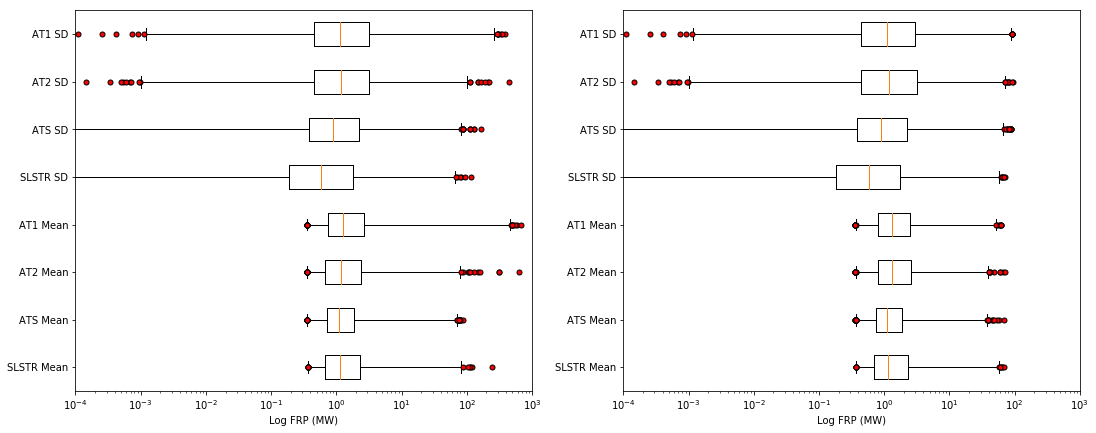

In [51]:
plt.close('all')
errors_plot(at1_stats_df, at2_stats_df, ats_stats_df, sls_stats_df)

## Reducing to valid flares

In [52]:
# set max values from punta de mata venezuela
max_mean = 70.705
max_sd = 93.16

# do ats
aats_flare_df = ats_flare_df[ats_flare_df.sensor == 'ats']
aats_flare_df = aats_flare_df.merge(ats_stats_df[['frp_mean', 'frp_sd', 'lats_arcmin', 'lons_arcmin']], on=['lats_arcmin', 'lons_arcmin'])
s1 = aats_flare_df.shape[0]
print s1

excluded_df = aats_flare_df[~((aats_flare_df.frp_mean < max_mean) & (aats_flare_df.frp_sd < max_sd))]
print 'total excluded ATS:', excluded_df.drop_duplicates(['lats_arcmin', 'lons_arcmin']).shape[0]

aats_flare_df = aats_flare_df[(aats_flare_df.frp_mean < max_mean) & 
                              (aats_flare_df.frp_sd < max_sd)]
aats_flare_df.drop(['frp_mean', 'frp_sd'], axis=1, inplace=True)
s2 = aats_flare_df.shape[0]
print s2
print s2 * 1.0 / s1 * 100
print

# do at2
at2_flare_df = ats_flare_df[ats_flare_df.sensor == 'at2']
at2_flare_df = at2_flare_df.merge(at2_stats_df[['frp_mean', 'frp_sd', 'lats_arcmin', 'lons_arcmin']], on=['lats_arcmin', 'lons_arcmin'])
s1 = at2_flare_df.shape[0]
print s1

excluded_df = at2_flare_df[~((at2_flare_df.frp_mean < max_mean) & (at2_flare_df.frp_sd < max_sd))]
print 'total excluded AT2:', excluded_df.drop_duplicates(['lats_arcmin', 'lons_arcmin']).shape[0]

at2_flare_df = at2_flare_df[(at2_flare_df.frp_mean < max_mean) & 
                              (at2_flare_df.frp_sd < max_sd)]
at2_flare_df.drop(['frp_mean', 'frp_sd'], axis=1, inplace=True)
s2 = at2_flare_df.shape[0]
print s2
print s2 * 1.0 / s1 * 100 
print

# do at1
at1_flare_df = ats_flare_df[ats_flare_df.sensor == 'at1']
at1_flare_df = at1_flare_df.merge(at1_stats_df[['frp_mean', 'frp_sd', 'lats_arcmin', 'lons_arcmin']], on=['lats_arcmin', 'lons_arcmin'])
s1 = at1_flare_df.shape[0]
print s1

excluded_df = at1_flare_df[~((at1_flare_df.frp_mean < max_mean) & (at1_flare_df.frp_sd < max_sd))]
print 'total excluded AT1:', excluded_df.drop_duplicates(['lats_arcmin', 'lons_arcmin']).shape[0]

at1_flare_df = at1_flare_df[(at1_flare_df.frp_mean < max_mean) & 
                            (at1_flare_df.frp_sd < max_sd)]

at1_flare_df.drop(['frp_mean', 'frp_sd'], axis=1, inplace=True)
s2 = at1_flare_df.shape[0]
print s2
print s2 * 1.0 / s1 * 100
print

# join back together
ats_flare_df = pd.concat([aats_flare_df, at2_flare_df, at1_flare_df], ignore_index=True)



1878111
total excluded ATS: 1192
1876828
99.9316866788

684220
total excluded AT2: 3218
680433
99.4465230481

426762
total excluded AT1: 2296
423371
99.2054119158



Let visualise again to see if the strange AT1 data has been removed:

In [53]:
print ats_flare_df.drop_duplicates(['lats_arcmin', 'lons_arcmin']).shape[0]
print ats_flare_df[ats_flare_df.sensor == 'ats'].drop_duplicates(['lats_arcmin', 'lons_arcmin']).shape[0]
print ats_flare_df[ats_flare_df.sensor == 'at2'].drop_duplicates(['lats_arcmin', 'lons_arcmin']).shape[0]
print ats_flare_df[ats_flare_df.sensor == 'at1'].drop_duplicates(['lats_arcmin', 'lons_arcmin']).shape[0]
print sls_flare_df.drop_duplicates(['lats_arcmin', 'lons_arcmin']).shape[0]

26083
21295
17904
12097
11262


Now lets redo the sampling analysis to consider only persistent hotspots assocaited with flainr!  We do not care about the sampling of non-flare hotspots!

# ------- EVALUATE FLARE SAMPLING STATISTICS -------

In [54]:
# reduce sampling dataframes to hotspot dataframes
ats_flare_sampling_df = ats_hotspot_sampling_df.merge(ats_flare_df[['lats_arcmin', 'lons_arcmin']].drop_duplicates(),
                                                        on=['lats_arcmin', 'lons_arcmin'])

In [55]:
sls_flare_sampling_df = sls_hotspot_sampling_df.merge(sls_flare_df[['lats_arcmin', 'lons_arcmin']].drop_duplicates(), 
                                                        on=['lats_arcmin', 'lons_arcmin'])

## Exploring Sampling Cloud Cover across the sensors

Looking at the sampling dataframe first it can be seen that the SLSTR data has too low cloud cover for 2017, cause is currently unknown.  THe same is found for AT1, and that can be corrected for using the data from ATS and AT2 as all sensors use the same map so the sampling will be made across all sensors at the given locations.  For SLSTR we cannot so easily use the ATX sampling to adjust as the flaring map is different so not all the points observed in SLSTR are avialable in the ATX maps.  This suggests that we should use the SLSTR map to generate the sampling data from ATSR as could then use the cloud cover statistics from these ATSR data to update the data for SLSTR.  As a workaround, we could just you cloud statistics from the nearest ATX sample to update the cloud cover for SLSTR, and it does need to be updated to get reliable estimates of flaring activity in terms of FRP. 

In [56]:
global_sampling = sls_flare_sampling_df.groupby(['year', 'sensor'], as_index=False).agg({'sample_counts_all': np.sum,
                                                                              'cloud_cover': np.mean})
global_sampling

,year,sensor,sample_counts_all,cloud_cover
0,2017.0,sls,1144461,0.404539
1,2018.0,sls,735978,0.412262


We do the same analysis done above for the SLSTR data on the ATX data.  It is apparent that the annual mean cloud cover for AT1 is too low.  It should be aroun 60% and is typically far lower than this.  This is due to deficiencies in the cloud masking avaialble on AT1.  So we need to update the sampling cloud cover values for AT1 in an approrpiate way so that they reflect typical cloud cover for a given features.  Also note that the total sample counts in some yeasrs is too low (considering only full years of operation).  This is indicative of poor sensor behaviour in those years, and must be mentioned in the paper.

In [57]:
# get the global annual FRP values
global_sampling = ats_flare_sampling_df.groupby(['year', 'sensor'], as_index=False).agg({'sample_counts_all': np.sum,
                                                                              'cloud_cover': np.mean})
global_sampling

,year,sensor,sample_counts_all,cloud_cover
0,1991.0,at1,708397,0.569784
1,1992.0,at1,1747059,0.465828
2,1993.0,at1,1901109,0.371173
3,1994.0,at1,1908243,0.336463
4,1995.0,at1,1843012,0.378199
5,1996.0,at1,876837,0.411917
6,1996.0,at2,1101700,0.596817
7,1997.0,at2,2178329,0.602030
8,1998.0,at2,2130302,0.598983
9,1999.0,at2,2048695,0.613651


## Updating AT1 Cloud Cover Percentages 

To update the AT1 cloud cover percentages first the non AT1 samples are extracted into a new dataframe.  These non AT1 samples are then grouped by lat and lon, taking the mean cloud cover for each sample location.  A new sensor column is added to the grouped data, and the sensor is assinged as AT1.  Also, the cloud cover column name is reset to updated_cloud_cover.  The modified grouped dataframe is then merged back on to the main sampling dataframe by lat lon and sensor.  All AT1 rows now have an updated cloud cover value associated with them, and this updated cloud cover is used to provide an update to the original cloud cover column.  In effect the cloud cover column in every AT1 row is assigned the updated cloud cover value.  Lastly, the updated cloud cover column is dropped from the sampling dataframe as it is no longer needed.  

In [58]:
def update_at1_cloud_cover(ats_sampling_df):
    not_at1_sampling = ats_sampling_df[ats_sampling_df.sensor !='at1'].copy()
    not_at1_sampling_mean_cc = not_at1_sampling.groupby(['lats_arcmin', 'lons_arcmin'], as_index=False).agg({'cloud_cover':np.mean})
    not_at1_sampling_mean_cc['sensor'] = 'at1'
    not_at1_sampling_mean_cc.rename(columns={'cloud_cover':'updated_cloud_cover'}, inplace=True)
    ats_sampling_df = ats_sampling_df.merge(not_at1_sampling_mean_cc, on=['lats_arcmin', 'lons_arcmin', 'sensor'], how='outer')
    print 'Number at1 sampling locations no updated:', np.sum((ats_sampling_df.sensor=='at1') & (~ats_sampling_df.updated_cloud_cover.notnull()))
    
    mask = ats_sampling_df.updated_cloud_cover.notnull()
    ats_sampling_df.cloud_cover.loc[mask] = ats_sampling_df.updated_cloud_cover.loc[mask]
    ats_sampling_df.drop('updated_cloud_cover', axis=1, inplace=True)
    return ats_sampling_df

In [59]:
ats_flare_sampling_df = update_at1_cloud_cover(ats_flare_sampling_df)

Number at1 sampling locations no updated: 0


Checking the sampling data again, we can see that the AT1 cloud cover statistics are now more representative of those across the AT2 and ATS data.  So the values at each individual AT1 flare will now be much more realistic.

In [60]:
# get the global annual FRP values
global_sampling = ats_flare_sampling_df.groupby(['year', 'sensor'], as_index=False).agg({'sample_counts_all': np.sum,
                                                                              'cloud_cover': np.mean})
global_sampling

,year,sensor,sample_counts_all,cloud_cover
0,1991.0,at1,708397,0.604478
1,1992.0,at1,1747059,0.601497
2,1993.0,at1,1901109,0.600951
3,1994.0,at1,1908243,0.602570
4,1995.0,at1,1843012,0.600449
5,1996.0,at1,876837,0.604399
6,1996.0,at2,1101700,0.596817
7,1997.0,at2,2178329,0.602030
8,1998.0,at2,2130302,0.598983
9,1999.0,at2,2048695,0.613651


## Updating SLS Cloud Cover Percentages 

In the case of SLSTR we do not have ATS samples avialable for all SLSTR hotspot sampling locations.  So instead we locate the approximate nearest hotspot using euclidean distance metric and assigne each SLSTR sampling grid cell the cloud cover from the ATX sampled dataframe.  We do not need to be exact here as cloud cover regimes ares consistent over hundreds of kilometres.   

In [61]:
def update_slstr_cloud_cover(ats_sampling_df, sls_sampling_df):
    
    # group ATS data to unique sample locations and get cc and loc
    ats_sampling_mean_cc = ats_sampling_df.groupby(['lats_arcmin', 'lons_arcmin'], as_index=False).agg({'cloud_cover':np.mean})
    ats_cloud_cover = ats_sampling_mean_cc.cloud_cover.values
    ats_lats = ats_sampling_mean_cc.lats_arcmin.values
    ats_lons = ats_sampling_mean_cc.lons_arcmin.values
    
    # group sls data to unique sample locations
    sls_sampling_mean_cc = sls_sampling_df.groupby(['lats_arcmin', 'lons_arcmin'], as_index=False).agg({'cloud_cover':np.mean})
    sls_sampling_mean_cc.drop('cloud_cover', axis=1, inplace=True)
    sls_lats = sls_sampling_mean_cc.lats_arcmin.values
    sls_lons = sls_sampling_mean_cc.lons_arcmin.values
    
    ats_lat_lon = np.dstack([np.deg2rad(ats_lats), 
                              np.deg2rad(ats_lons)])[0]
    ats_balltree = BallTree(ats_lat_lon, metric='euclidean')

    # get the unique flare lats and lons for assessment in kdtree
    sls_locations = np.array(zip(np.deg2rad(sls_lats), 
                                   np.deg2rad(sls_lons)))

    # compare the flare locations to the potential locations in the orbit
    distances, indexes = ats_balltree.query(sls_locations, k=1) 
    
    # get update cc and append to df
    updated_cc = ats_cloud_cover[indexes]
    sls_sampling_mean_cc['cloud_cover'] = updated_cc
    
    # merge updated grouped data onto sls dataframe
    sls_sampling_df.drop('cloud_cover', axis=1, inplace=True)
    sls_sampling_df = sls_sampling_df.merge(sls_sampling_mean_cc, on=['lats_arcmin', 'lons_arcmin'], how='outer')

    return sls_sampling_df

In [62]:
sls_flare_sampling_df = update_slstr_cloud_cover(ats_flare_sampling_df, sls_flare_sampling_df.copy())

In [63]:
# get the global annual FRP values
global_sampling = sls_flare_sampling_df.groupby(['year', 'sensor'], as_index=False).agg({'sample_counts_all': np.sum,
                                                                              'cloud_cover': np.mean})
global_sampling

,year,sensor,sample_counts_all,cloud_cover
0,2017.0,sls,1144461,0.565730
1,2018.0,sls,735978,0.578964


## Sampling Stats

In [64]:
print 'n persistent ats:', ats_flare_sampling_df.drop_duplicates(['lats_arcmin', 'lons_arcmin']).shape[0]

gp = ats_flare_sampling_df.groupby(['lats_arcmin', 'lons_arcmin']).agg({'sample_counts_all':np.sum})
print gp.sample_counts_all.mean()
print gp.sample_counts_all.std()

print 'n persistent sls:', sls_flare_sampling_df.drop_duplicates(['lats_arcmin', 'lons_arcmin']).shape[0]

gp = sls_flare_sampling_df.groupby(['lats_arcmin', 'lons_arcmin']).agg({'sample_counts_all':np.sum})
print gp.sample_counts_all.mean()
print gp.sample_counts_all.std()

n persistent ats: 26083
1718.61112602
211.883459569
n persistent sls: 11262
166.972029835
27.4990456671


# ------- VIIRS COMPARISON: DETECTION -------

In [ ]:
## ATS Flare persistency

In [ ]:
args = ['lats_arcmin', 'lons_arcmin', 'year', 'month', 'day']
ats_flare_locations = ats_flare_df.drop_duplicates(args)[args]
ats_flare_locations['min_time'] =  pd.to_datetime((ats_flare_locations.year*10000+ats_flare_locations.month*100+ats_flare_locations.day).apply(str),format='%Y%m%d')
ats_flare_locations['max_time'] =  pd.to_datetime((ats_flare_locations.year*10000+ats_flare_locations.month*100+ats_flare_locations.day).apply(str),format='%Y%m%d')

ats_flare_locations = ats_flare_locations.groupby(['lats_arcmin', 'lons_arcmin'], as_index=False).agg({'min_time':np.min, 'max_time': np.max})

t_dff = ats_flare_locations.max_time - ats_flare_locations.min_time


In [ ]:
t_dff.describe()

# VIIRS Industrial Activity vs. ATX and SLS (Flare detection eval)

First plot VIIRS flares into flaring and non-flaring hotspots:

In [ ]:
viirs_industrial_df['is_flare'] = viirs_industrial_df.name_id == 4
viirs_industrial_df['sample_counts_flare'] = 10
viirs_industrial_df = dist_to_nearest_volcano(volc_df, viirs_industrial_df)

plot_data_screening(viirs_industrial_df, '(c)', 'viirs_hotspots.png', leg=False)

# Comparing Detections within 1 arcminute for all sensors

In [259]:
def within_dist(target_df, observed_df):
    '''
    The target dataframe contains the assumed TRUE flares.  We compare all flares in 
    the observed dataframe to this flares in the target df, and if the observed flare
    is within 2km of any target flares then it is flagged as being a match (i.e. observes
    a flare in the same location as the target df)
    '''
    
    target_lat_lon = np.dstack([target_df.lats_arcmin.values, target_df.lons_arcmin.values])[0]
    target_balltree = BallTree(target_lat_lon, metric='euclidean')

    # get the unique flare lats and lons for assessment in kdtree
    observed_locations = np.array(zip(observed_df.lats_arcmin.values, observed_df.lons_arcmin.values))

    # compare the flare locations to the potential locations in the orbit
    distances, indexes = target_balltree.query(observed_locations, k=1) 

    # set up the dataframe to hold the distances
    mask = distances < np.sqrt(2)  # if within 1 grid cell (sqrt 2 includes corners)
    observed_df['within_arcmin'] = mask
    return observed_df

In [ ]:
agg_dict = {'name_id': lambda x:stats.mode(x)[0][0],
            'lats': np.mean,
            'lons': np.mean}
viirs_unique_flares = viirs_industrial_df.groupby(['lats_arcmin', 'lons_arcmin'], as_index=False).agg(agg_dict)
viirs_unique_flares = viirs_unique_flares[viirs_unique_flares.name_id == 4]
viirs_unique_flares.drop('name_id', axis=1, inplace=True)

ats_unique_flares = ats_flare_df.drop_duplicates(['lats_arcmin', 'lons_arcmin'])[['lats_arcmin', 'lons_arcmin', 'lats','lons']]
sls_unique_flares = sls_flare_df.drop_duplicates(['lats_arcmin', 'lons_arcmin'])[['lats_arcmin', 'lons_arcmin', 'lats','lons']]

In [ ]:
# adding country level data
ats_unique_flares = ats_unique_flares.merge(ats_countries_df[['countries', 'lats_arcmin', 'lons_arcmin']],  on=['lats_arcmin', 'lons_arcmin'])
sls_unique_flares = sls_unique_flares.merge(sls_countries_df[['countries', 'lats_arcmin', 'lons_arcmin']],  on=['lats_arcmin', 'lons_arcmin'])
viirs_unique_flares = viirs_unique_flares.merge(viirs_countries_df[['countries', 'lats_arcmin', 'lons_arcmin']],  on=['lats_arcmin', 'lons_arcmin'])


In [ ]:
# dist_to_nearest(target, orbsered)
viirs_unique_flares_ats = within_dist(ats_unique_flares.copy(), viirs_unique_flares.copy())
viirs_unique_flares_sls = within_dist(sls_unique_flares.copy(), viirs_unique_flares.copy())
sls_unique_flares_viirs = within_dist(viirs_unique_flares.copy(), sls_unique_flares.copy())
sls_unique_flares_ats = within_dist(ats_unique_flares.copy(), sls_unique_flares.copy())
ats_unique_flares_viirs = within_dist(viirs_unique_flares.copy(), ats_unique_flares.copy())
ats_unique_flares_sls = within_dist(sls_unique_flares.copy(), ats_unique_flares.copy())


## Global matching statistics

In [ ]:
print 'ats matched / viirs observed:', np.sum(viirs_unique_flares_ats.within_arcmin) * 1.0/ viirs_unique_flares_ats.shape[0]* 100,'%', np.sum(viirs_unique_flares_ats.within_arcmin), viirs_unique_flares_ats.shape[0]
print 'sls matched / viirs observed:', np.sum(viirs_unique_flares_sls.within_arcmin) * 1.0/ viirs_unique_flares_sls.shape[0]* 100,'%', np.sum(viirs_unique_flares_sls.within_arcmin), viirs_unique_flares_sls.shape[0]
print 'viirs matched / ats observed:', np.sum(ats_unique_flares_viirs.within_arcmin) * 1.0/ ats_unique_flares_viirs.shape[0]* 100,'%', np.sum(ats_unique_flares_viirs.within_arcmin), ats_unique_flares_viirs.shape[0]
print 'sls matched / ats observed:', np.sum(ats_unique_flares_sls.within_arcmin) * 1.0/ ats_unique_flares_sls.shape[0]* 100,'%', np.sum(ats_unique_flares_sls.within_arcmin), ats_unique_flares_sls.shape[0]
print 'viirs matched / sls observed:', np.sum(sls_unique_flares_viirs.within_arcmin) * 1.0/ sls_unique_flares_viirs.shape[0]* 100,'%', np.sum(sls_unique_flares_viirs.within_arcmin), sls_unique_flares_viirs.shape[0]
print 'ats matched / sls observed:', np.sum(sls_unique_flares_ats.within_arcmin) * 1.0/ sls_unique_flares_ats.shape[0]* 100,'%', np.sum(sls_unique_flares_ats.within_arcmin), sls_unique_flares_ats.shape[0]


## Country Matching Statistics

In [ ]:
# get top countries according to VIIRS
viirs_top_20 = viirs_unique_flares.groupby('countries').countries.count().sort_values(ascending=False)[0:20]
top_20_countries = viirs_top_20.index.values
top_20_countries.sort()
print 'VIIRS top 20 covers:', viirs_top_20.sum() * 1.0 / viirs_unique_flares.shape[0], '% of flares'

In [ ]:
viirs_unique_flares_ats_t20 = viirs_unique_flares_ats[viirs_unique_flares_ats['countries'].isin(top_20_countries)]
viirs_unique_flares_sls_t20 = viirs_unique_flares_sls[viirs_unique_flares_sls['countries'].isin(top_20_countries)]
sls_unique_flares_viirs_t20 = sls_unique_flares_viirs[sls_unique_flares_viirs['countries'].isin(top_20_countries)]
sls_unique_flares_ats_t20 = sls_unique_flares_ats[sls_unique_flares_ats['countries'].isin(top_20_countries)]
ats_unique_flares_viirs_t20 = ats_unique_flares_viirs[ats_unique_flares_viirs['countries'].isin(top_20_countries)]
ats_unique_flares_sls_t20 = ats_unique_flares_sls[ats_unique_flares_sls['countries'].isin(top_20_countries)]

In [ ]:
viirs_ats_ratio = []
viirs_sls_ratio = []
sls_viirs_ratio = []
sls_ats_ratio = []
ats_viirs_ratio = []
ats_sls_ratio = []

for c in top_20_countries:
    
    c_df = viirs_unique_flares_ats_t20[viirs_unique_flares_ats_t20.countries == c]
    viirs_ats_ratio.append(c_df.within_arcmin.sum() * 1.0 / c_df.shape[0]* 100)
    
    c_df = viirs_unique_flares_sls_t20[viirs_unique_flares_sls_t20.countries == c]
    viirs_sls_ratio.append(c_df.within_arcmin.sum() * 1.0 / c_df.shape[0]* 100)
    
    c_df = sls_unique_flares_viirs_t20[sls_unique_flares_viirs_t20.countries == c]
    sls_viirs_ratio.append(c_df.within_arcmin.sum() * 1.0 / c_df.shape[0]* 100)
    
    c_df = sls_unique_flares_ats_t20[sls_unique_flares_ats_t20.countries == c]
    sls_ats_ratio.append(c_df.within_arcmin.sum() * 1.0 / c_df.shape[0] * 100)
    
    c_df = ats_unique_flares_viirs_t20[ats_unique_flares_viirs_t20.countries == c]
    ats_viirs_ratio.append(c_df.within_arcmin.sum() * 1.0 / c_df.shape[0]* 100)
    
    c_df = ats_unique_flares_sls_t20[ats_unique_flares_sls_t20.countries == c]
    ats_sls_ratio.append(c_df.within_arcmin.sum() * 1.0 / c_df.shape[0]* 100)
    

In [ ]:
for i, c in enumerate(top_20_countries):
    print c, viirs_ats_ratio[i], viirs_sls_ratio[i], sls_ats_ratio[i], sls_viirs_ratio[i], ats_sls_ratio[i],  ats_viirs_ratio[i]

In [ ]:
# do the plot
plt.close('all')
fig = plt.figure(figsize=(14, 7))
ax0 = plt.subplot(131)
ax1 = plt.subplot(132)
ax2 = plt.subplot(133)

ind = np.arange(0, 20)

ax0.barh(ind, viirs_sls_ratio, height=0.4, align='edge', color='gray', label = 'S/V')
ax0.barh(ind-0.4, viirs_ats_ratio, height=0.4, align='edge', color='r', label='A/V')
ax0.set_yticks(ind)
ax0.set_xlim([0,100])
ax0.set_ylim([-1,20.5])
ax0.plot([50, 50], [-10, 30], 'k--')
ax0.set_yticklabels(top_20_countries)
ax0.legend()
ax0.set(ylabel='Top 20 Countries', xlabel='Percent Matched')
ax0.yaxis.label.set_size(12)
ax0.xaxis.label.set_size(12)


ax1.barh(ind, sls_viirs_ratio, height=0.4, align='edge', color='gray', label='V/S')
ax1.barh(ind-0.4, sls_ats_ratio, height=0.4, align='edge', color='b', label='A/S')
ax1.set_yticks(ind)
ax1.set_xlim([0,100])
ax1.set_ylim([-1,20.5])
ax1.plot([50, 50], [-10, 30], 'k--')
ax1.set_yticklabels('')
ax1.legend()
ax1.set(xlabel='Percent Matched')
ax1.xaxis.label.set_size(12)


ax2.barh(ind, ats_viirs_ratio, height=0.4, align='edge', color='gray', label='V/A')
ax2.barh(ind-0.4, ats_sls_ratio, height=0.4, align='edge', color='y', label='S/A')
ax2.set_yticks(ind)
ax2.set_xlim([0,100])
ax2.set_ylim([-1,20.5])
ax2.plot([50, 50], [-10, 30], 'k--')
ax2.set_yticklabels('')
ax2.legend()
ax2.set(xlabel='Percent Matched')
ax2.xaxis.label.set_size(12)

plt.savefig(os.path.join(output_path, 'detection_bar_charts.png'), bbox_inches='tight', dpi=600)
plt.show()



From the above ATSR sees a lot of the VIIRS and SLSTR flares.  Problem area seems to be the states. Why?

## FRP in North America Comparison (in one month!)
We have the December 2017 VIIRS data.  Assume that over the States in the month of December there are limited wildfires.  We restrict to only those points that are >1400K to be consistent with the thresholds applied to VIIRS.  The SLSTR data is screened by needing to have at least two detections and a suitable threshold that places it between 1400 and 2800K.  Using this assumed flare data subset over North America.

Ths can be visualsied by two cumulative histograms and individual statistics reported

Ideas for the observed behaviour:

Flares could be operating more intermittantly.  So we are not getting the correct behaviour as we are observing less frequnetly, so are missing a lot of the flaring activity.  This can be checked by processing all of the SLSTR data and evaluating off swath.  Or all of the VIIRS data and evaluting only to the same view angles.

In [ ]:
# Get SLSTR first (using annum data)
sls_df_subset = sls_flare_df_annum[['frp', 'year', 'month', 'lats_arcmin', 'lons_arcmin']]
sls_df_subset = sls_df_subset.merge(sls_countries_df[['countries', 'lats_arcmin', 'lons_arcmin']],  
                                    on=['lats_arcmin', 'lons_arcmin'])
sls_df_subset = sls_df_subset[((sls_df_subset.countries == 'United States') | 
                              (sls_df_subset.countries == 'Canada')) & 
                              (sls_df_subset.year == 2017) &
                              (sls_df_subset.month == 12)
                             ]
sls_df_grouped = sls_df_subset.groupby(['lats_arcmin', 'lons_arcmin'], as_index=False).agg({'frp': np.mean})


# get Nightfire DS and add VZA data
nightfire_df_subset = nightfire_df[['RH', 'Temp_BB', 'lats_arcmin', 'lons_arcmin', 'Sample_M10']]
nightfire_df_subset = nightfire_df_subset.merge(nightfire_countries_df[['countries', 'lats_arcmin', 'lons_arcmin']], 
                                                on=['lats_arcmin', 'lons_arcmin'])
vza = viirs_zenith_angles[nightfire_df_subset.Sample_M10.values.astype(int)-1].astype('float')
nightfire_df_subset['vza'] = vza

# all viirs flare data
nightfire_df_subset_all = nightfire_df_subset[(nightfire_df_subset.RH != 999999) & 
                                          (nightfire_df_subset.Temp_BB > 1600) &
                                          ((nightfire_df_subset.countries == 'United States') | 
                                          (nightfire_df_subset.countries == 'Canada'))]
nightfire_df_grouped_all = nightfire_df_subset_all.groupby(['lats_arcmin', 'lons_arcmin'], 
                                                       as_index=False).agg({'RH': np.mean})

# all VIIRS in VZA
nightfire_df_subset_vza = nightfire_df_subset_all[nightfire_df_subset_all.vza < 22]
nightfire_df_grouped_vza = nightfire_df_subset_vza.groupby(['lats_arcmin', 'lons_arcmin'], 
                                                           as_index=False).agg({'RH': np.mean})

# # all VIIRS > min SLS FRP value
nightfire_df_subset_min = nightfire_df_subset_vza[nightfire_df_subset_vza.RH > sls_df_grouped.frp.min()]
nightfire_df_grouped_min = nightfire_df_subset_min.groupby(['lats_arcmin', 'lons_arcmin'], 
                                                           as_index=False).agg({'RH': np.mean})


# 
plt.close('all')
fig = plt.figure(figsize=(7, 7))
ax0 = plt.subplot(111)
ax0.set_xlim([0,18])

ax0.set_xlabel('Binned FRP (MW)', fontsize=18)
ax0.set_ylabel('Bin Count', fontsize=18)

ax0.hist(nightfire_df_grouped_all.RH, bins=50, histtype='step', cumulative=True, color='gray', label='All VIIRS')
ax0.hist(nightfire_df_grouped_vza.RH, bins=50, histtype='bar', cumulative=True, color='gray', label='VIIRS (VZA<22)')
ax0.hist(nightfire_df_grouped_min.RH, bins=50, histtype='bar', cumulative=True, color='r', label='VIIRS (>min(SLSTR))')
ax0.hist(sls_df_grouped.frp, bins=50, histtype='bar', cumulative=True, color='k', label='SLSTR (VZA<22)')
plt.legend(loc=1)
plt.savefig(os.path.join(output_path, 'NA_flare_counts_viirs_vs_slstr.png'), bbox_inches='tight', dpi=600)
plt.show()


## Global matching statistics (NO US/Canada/China)

In [ ]:
c = ['United States', 'Canada', 'China']
m = ~viirs_unique_flares_ats['countries'].isin(c)
print 'ats matched / viirs observed:', np.sum(viirs_unique_flares_ats.loc[m].within_arcmin) * 1.0/ np.sum(m) * 100,'%', np.sum(viirs_unique_flares_ats.loc[m].within_arcmin), np.sum(m) 
m = ~viirs_unique_flares_sls['countries'].isin(c)
print 'sls matched / viirs observed:', np.sum(viirs_unique_flares_sls.loc[m].within_arcmin) * 1.0/ np.sum(m)* 100,'%', np.sum(viirs_unique_flares_sls.loc[m].within_arcmin), np.sum(m) 
m = ~ats_unique_flares_viirs['countries'].isin(c)
print 'viirs matched / ats observed:', np.sum(ats_unique_flares_viirs.loc[m].within_arcmin) * 1.0/ np.sum(m)* 100,'%', np.sum(ats_unique_flares_viirs.loc[m].within_arcmin), np.sum(m) 
m = ~ats_unique_flares_sls['countries'].isin(c)
print 'sls matched / ats observed:', np.sum(ats_unique_flares_sls.loc[m].within_arcmin) * 1.0/ np.sum(m)* 100,'%', np.sum(ats_unique_flares_sls.loc[m].within_arcmin), np.sum(m) 
m = ~sls_unique_flares_viirs['countries'].isin(c)
print 'viirs matched / sls observed:', np.sum(sls_unique_flares_viirs.loc[m].within_arcmin) * 1.0/ np.sum(m)* 100,'%', np.sum(sls_unique_flares_viirs.loc[m].within_arcmin), np.sum(m) 
m = ~sls_unique_flares_ats['countries'].isin(c)
print 'ats matched / sls observed:', np.sum(sls_unique_flares_ats.loc[m].within_arcmin) * 1.0/ np.sum(m)* 100,'%', np.sum(sls_unique_flares_ats.loc[m].within_arcmin), np.sum(m) 


# ------- VIIRS COMPARISON: CHARACTERISATION -------

# VIIRS vs. ATX and SLS OVER IRAQ

In this analysis we do not use the cloud adjusted FRP values as we are not worrying about sampling differences, we just assume that the cloud characterisitics are similar for each sensor (which may be wrong as we are looking at different times of the day) and take the mean of the observations.  We could get all the nighttime VIIRS obs to do this, but think it is unecessary.  This uses data from March

In [475]:
# make sure that the march SLSTR data is restricted to flares only
sls_0317_flares = sls_hotspot_df_0317.copy()
sls_flare_locations = sls_flare_sampling_df_annum[['lats_arcmin', 'lons_arcmin']]
sls_flare_locations.drop_duplicates(inplace=True)

# restrict to flaring sites only
print sls_0317_flares.shape
sls_0317_flares = pd.merge(sls_0317_flares, sls_flare_locations, on=['lats_arcmin', 'lons_arcmin'])
print sls_0317_flares.shape

(26282, 19)
(16159, 19)


/Users/danielfisher/anaconda2/envs/kcl-globalgasflaring/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [480]:
sls_hotspot_df_0317[sls_hotspot_df_0317.lats_arcmin == 3628].head(10)

,Unnamed: 0,lats_arcmin,lons_arcmin,swir_radiances_22,frp,lats,vza,cloud_cover,swir_radiances,sza,lons,pixel_size,year,month,day,hhmm,sensor,frp_coeff,sample_counts_flare
6,6,3628,6051,0.468202,0.817654,36.466667,8.657380,0.902663,0.431278,132.061780,60.850000,274139.798206,2017,3,1,1725,sls,6.915764,1
7,7,3628,6052,0.437780,1.374973,36.466667,8.630370,0.906336,0.724818,132.064885,60.866667,274299.587507,2017,3,1,1725,sls,6.915764,1
239,239,3628,6051,0.468202,0.817654,36.466667,8.657435,0.893480,0.431278,132.061764,60.850000,274139.798206,2017,3,1,1725,sls,6.915764,1
240,240,3628,6052,0.437780,1.374973,36.466667,8.630372,0.896235,0.724818,132.064881,60.866667,274299.587507,2017,3,1,1725,sls,6.915764,1
7699,7699,3628,6051,0.683382,3.250472,36.466667,19.059777,0.958678,0.785784,128.919439,60.850000,598140.373732,2017,3,9,1718,sls,6.915764,1
7994,7994,3628,6051,0.683382,3.250472,36.466667,19.059786,0.957759,0.785784,128.919434,60.850000,598140.373732,2017,3,9,1718,sls,6.915764,1
14799,14799,3628,11257,0.461524,0.926340,36.466667,17.825009,0.097337,0.483212,129.672615,112.950000,277199.476957,2017,3,20,1411,sls,6.915764,1
15450,15450,3628,11257,0.461524,0.926340,36.466667,17.824981,0.094582,0.483212,129.672544,112.950000,277199.476957,2017,3,20,1411,sls,6.915764,1
22259,22259,3628,6051,0.365064,0.707019,36.466667,8.598827,0.422406,0.372570,125.416143,60.850000,274399.489164,2017,3,28,1725,sls,6.915764,1
22260,22260,3628,6052,1.372700,3.633652,36.466667,8.572043,0.427916,1.914784,125.418547,60.866667,274399.489164,2017,3,28,1725,sls,6.915764,1


In [483]:
sls_flare_df[sls_flare_df.lats_arcmin == 3628].head(10)

,Unnamed: 0,lats_arcmin,lons_arcmin,swir_radiances_22,frp,lats,vza,cloud_cover,swir_radiances,sza,lons,pixel_size,year,month,day,hhmm,sensor,frp_coeff,sample_counts_flare
35630,27652,3628,6051,0.827330,4.017596,36.466667,13.758014,0.539486,1.068034,116.317297,60.85,543927.464973,2017,5,9,1737,sls,6.915764,1
35631,27733,3628,6051,0.827330,4.026619,36.466667,13.757878,0.528466,1.070292,116.317312,60.85,543998.956680,2017,5,9,1737,sls,6.915764,1
35632,28312,3628,6051,0.823991,4.009629,36.466667,13.757878,0.528466,1.065776,116.317312,60.85,543998.956680,2017,5,9,1737,sls,6.915764,1
35633,29767,3628,6051,0.373968,2.040950,36.466667,19.307436,0.258035,0.530630,112.564424,60.85,556160.844776,2017,6,1,1740,sls,6.915764,1
35634,30080,3628,6051,0.373968,1.020475,36.466667,19.307439,0.276400,0.530630,112.564347,60.85,278080.422388,2017,6,1,1740,sls,6.915764,1
35635,32484,3628,6051,1.687308,4.140757,36.466667,13.795922,0.842057,2.201550,111.664724,60.85,271963.732487,2017,6,5,1737,sls,6.915764,1
35636,35330,3628,6051,0.393260,1.947911,36.466667,8.768421,0.184573,0.521598,110.837011,60.85,539998.948574,2017,6,9,1733,sls,6.915764,1
35637,35634,3628,6051,0.393260,1.947911,36.466667,8.768417,0.186869,0.521598,110.836983,60.85,539998.948574,2017,6,9,1733,sls,6.915764,1
35638,38389,3628,6051,1.163456,2.735807,36.466667,6.160850,0.027548,1.458668,110.087047,60.85,271199.494600,2017,6,13,1729,sls,6.915764,1
35639,38592,3628,6051,1.162714,2.731572,36.466667,6.160845,0.027548,1.456410,110.087048,60.85,271199.494600,2017,6,13,1729,sls,6.915764,1


In [484]:
ats_hotspot_df[ats_hotspot_df.lats_arcmin == 3628].head(20)

,Unnamed: 0,lats_arcmin,lons_arcmin,bg_size_used,inval_pixels_bg_pc,mwir_bg,pixel_size,lats,hotspot_bg_pc,cloud_cover,...,mwir_radiances,lons,year,month,day,hhmm,sensor,se_dist,frp_coeff,sample_counts_flare
1978,1978,3628,6051,8,0.0,-1.000000,1.043233e+06,36.466667,0.006920,0.968858,...,0.118371,60.850002,2003,12,28,1727,ats,0.983348,6.832523,1
4354,4354,3628,11321,8,0.0,0.071251,3.452717e+06,36.466667,0.012605,0.025000,...,0.221964,113.350006,2003,12,25,1400,ats,0.983448,6.832523,1
4560,4560,3628,6050,8,0.0,-1.000000,9.504780e+05,36.466667,0.020761,0.740484,...,0.105989,60.833332,2003,12,25,1721,ats,0.983448,6.832523,1
4561,4561,3628,6051,8,0.0,-1.000000,9.507900e+05,36.466667,0.020761,0.709343,...,0.129245,60.850002,2003,12,25,1721,ats,0.983448,6.832523,1
4562,4562,3628,6052,8,0.0,-1.000000,9.511077e+05,36.466667,0.020761,0.705882,...,0.120904,60.866673,2003,12,25,1721,ats,0.983448,6.832523,1
6414,6414,3628,6051,8,0.0,0.097832,9.549886e+05,36.466667,0.010381,0.051903,...,0.254076,60.850002,2003,12,22,1715,ats,0.983593,6.832523,1
6485,6485,3628,11321,8,0.0,0.081290,9.849404e+05,36.466667,0.003460,0.038062,...,0.402152,113.350006,2003,12,22,1354,ats,0.983593,6.832523,1
7968,7968,3628,11140,8,0.0,0.066301,1.007493e+06,36.466667,0.003460,0.162630,...,0.124823,111.666672,2003,12,19,1348,ats,0.983781,6.832523,1
7969,7969,3628,11321,8,0.0,0.068496,9.419987e+05,36.466667,0.003460,0.055363,...,0.329563,113.350006,2003,12,19,1348,ats,0.983781,6.832523,1
8106,8106,3628,6050,8,0.0,-1.000000,2.117574e+06,36.466667,0.013841,0.986159,...,0.162744,60.833332,2003,12,19,1709,ats,0.983781,6.832523,1


In [372]:
def round_to_nearest_01_degree(s):
    return (s.round(1) * 10).astype(int)

In [380]:
viirs_persistent = viirs_iraq_hotspot_df.copy()
viirs_persistent['lats_01'] = round_to_nearest_01_degree(viirs_persistent.lats)
viirs_persistent['lons_01'] = round_to_nearest_01_degree(viirs_persistent.lons)

to_group = ['year', 'lats_01', 'lons_01']
to_agg = {'frp': np.mean,
          'lats': np.mean,
          'lons': np.mean}
viirs_persistent = viirs_persistent.groupby(to_group, as_index=False).agg(to_agg)
viirs_persistent['years_seen'] = 1

to_group = ['lats_01', 'lons_01']
to_agg = {'years_seen': np.sum}
viirs_persistent = viirs_persistent.groupby(to_group, as_index=False).agg(to_agg)

# find locations seen in both 2012 and 2017 data
viirs_persistent = viirs_persistent[viirs_persistent.years_seen == 2][['lats_01', 'lons_01']]
print 'total persistent viirs sites seen in 2012 and 2017:', viirs_persistent.shape[0]

total persistent viirs sites seen in 2012 and 2017: 458


In [381]:
# merge on the persistent sites to reduce the viirs data
viirs_sites = viirs_iraq_hotspot_df.copy()
viirs_sites['lats_01'] = round_to_nearest_01_degree(viirs_sites.lats)
viirs_sites['lons_01'] = round_to_nearest_01_degree(viirs_sites.lons)
viirs_sites = pd.merge(viirs_sites, viirs_persistent, on=['lats_01', 'lons_01'])

# load in comparison sites
ats_sites = ats_flare_df[(ats_flare_df.year == 2012) & (ats_flare_df.month == 3)].copy()
sls_sites = 

ats_sites['lats_01'] = round_to_nearest_01_degree(ats_sites.lats)
ats_sites['lons_01'] = round_to_nearest_01_degree(ats_sites.lons)

sls_sites['lats_01'] = round_to_nearest_01_degree(sls_sites.lats)
sls_sites['lons_01'] = round_to_nearest_01_degree(sls_sites.lons)


In [460]:
# now group the clusters by time stamp and sum frp for each time stamp
to_group = ['year', 'month', 'day', 'sensor', 'lats_01', 'lons_01']
to_agg = {'lats': np.mean, 'lons':np.mean, 'frp': np.mean}
viirs_sites_grouped = viirs_sites.groupby(to_group, as_index=False).agg(to_agg)
ats_sites_grouped = ats_sites.groupby(to_group, as_index=False).agg(to_agg)
sls_sites_grouped = sls_sites.groupby(to_group, as_index=False).agg(to_agg)

# now get the typical behaviour for each cluster over the year and month
to_group = ['year', 'month', 'sensor', 'lats_01', 'lons_01']
to_agg = {'lats': np.mean, 'lons':np.mean, 'frp': np.mean, 'frp_std': np.std}

viirs_sites_grouped['frp_std'] = viirs_sites_grouped.frp.copy()
ats_sites_grouped['frp_std'] = ats_sites_grouped.frp.copy()
sls_sites_grouped['frp_std'] = sls_sites_grouped.frp.copy()

viirs_sites_means = viirs_sites_grouped.groupby(to_group, as_index=False).agg(to_agg)
ats_sites_means = ats_sites_grouped.groupby(to_group, as_index=False).agg(to_agg)
sls_sites_means = sls_sites_grouped.groupby(to_group, as_index=False).agg(to_agg)

In [461]:
# now merge on year and cluster
viirs_sites_means.rename(columns={'frp': 'frp_viirs', 'frp_std': 'frp_std_viirs'}, inplace=True)
ats_sites_means.rename(columns={'frp': 'frp_ats', 'frp_std': 'frp_std_ats'}, inplace=True)
sls_sites_means.rename(columns={'frp': 'frp_sls', 'frp_std': 'frp_std_sls'}, inplace=True)

on = ['year', 'lats_01', 'lons_01']
cols_ats = ['year', 'lats_01', 'lons_01', 'frp_ats', 'frp_std_ats']
cols_sls = ['year', 'lats_01', 'lons_01', 'frp_sls', 'frp_std_sls']
cols_viirs = ['year', 'lats_01', 'lons_01', 'frp_viirs', 'frp_std_viirs', 'lats', 'lons']

ats_vs_viirs = pd.merge(viirs_sites_means[cols_viirs], ats_sites_means[cols_ats], on=on)
sls_vs_viirs =  pd.merge(viirs_sites_means[cols_viirs], sls_sites_means[cols_sls], on=on)
ats_vs_sls = pd.merge(ats_sites_means[cols_ats], sls_sites_means[cols_sls], on=['lats_01', 'lons_01'])

In [462]:
# mask
#ats_vs_viirs = ats_vs_viirs[(ats_vs_viirs.frp_ats < 150) & (ats_vs_viirs.frp_viirs < 150)]
#sls_vs_viirs = sls_vs_viirs[(sls_vs_viirs.frp_sls < 150) & (sls_vs_viirs.frp_viirs < 150)]

max_lat = 36
min_lat = 20
min_lon = 42
max_lon = 60
ats_vs_viirs = ats_vs_viirs[(ats_vs_viirs.lats < max_lat) & 
                            (ats_vs_viirs.lats > min_lat) & 
                            (ats_vs_viirs.lons > min_lon) & 
                            (ats_vs_viirs.lons < max_lon)]

sls_vs_viirs = sls_vs_viirs[(sls_vs_viirs.lats < max_lat) & 
                            (sls_vs_viirs.lats > min_lat) & 
                            (sls_vs_viirs.lons > min_lon) & 
                            (sls_vs_viirs.lons < max_lon)]


ats median: -0.053541809041
sls median: -0.173227386537

sls scaling factor:  [ 0.86862761]
adjusted sls median: 0.0474683508955
adjusted sls mean: -0.386558015443
adjusted sls sd: 4.61279288821


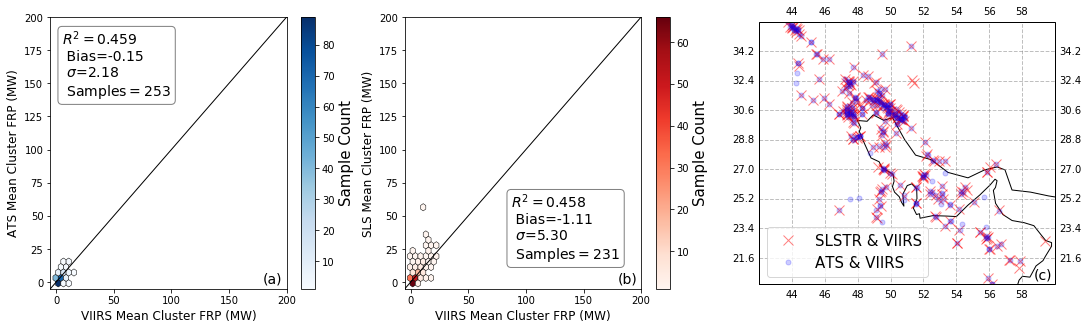

In [463]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

plt.close('all')
fig = plt.figure(figsize=(18, 5))
ax0 = plt.subplot(131)
ax1 = plt.subplot(132)
ax2 = plt.subplot(133, projection=ccrs.PlateCarree())

h = ax0.hexbin(ats_vs_viirs.frp_viirs, ats_vs_viirs.frp_ats, gridsize=45, mincnt=1,
          cmap='Blues', linewidths=0.5, edgecolors='k',extent=[-5, 200, -5, 200])
cbar = plt.colorbar(mappable=h, ax=ax0).set_label('Sample Count', fontsize=15)

h = ax1.hexbin(sls_vs_viirs.frp_viirs, sls_vs_viirs.frp_sls, gridsize=45, mincnt=1,
          cmap='Reds', linewidths=0.5, edgecolors='k', extent=[-5, 200, -5, 200])
cbar = plt.colorbar(mappable=h, ax=ax1).set_label('Sample Count', fontsize=15)

# sns.regplot(ats_vs_viirs.frp_viirs, ats_vs_viirs.frp_ats, ci=95, color='k', ax=ax0, scatter=False)
# sns.regplot(sls_vs_viirs.frp_viirs, sls_vs_viirs.frp_sls, ci=95, color='k', ax=ax1, scatter=False)

ax0.text(0.90, 0.02, '(a)', transform=ax0.transAxes, fontsize=14)
ax1.text(0.90, 0.02, '(b)', transform=ax1.transAxes, fontsize=14)
ax2.text(0.93, 0.02, '(c)', transform=ax2.transAxes, fontsize=14)


x_lim = (-5,200)
y_lim = (-5,200)
ax0.plot(x_lim, y_lim, color='k', linestyle='-', linewidth=1)
ax1.plot(x_lim, y_lim, color='k', linestyle='-', linewidth=1)

# ax0.set_xlim(x_lim)
# ax1.set_xlim(x_lim)

# ax0.set_ylim(y_lim)
# ax1.set_ylim(y_lim)

ax0.set(ylabel='ATS Mean Cluster FRP (MW)', xlabel='VIIRS Mean Cluster FRP (MW)')
ax0.yaxis.label.set_size(12)
ax0.xaxis.label.set_size(12)

ax1.set(ylabel='SLS Mean Cluster FRP (MW)', xlabel='VIIRS Mean Cluster FRP (MW)')
ax1.yaxis.label.set_size(12)
ax1.xaxis.label.set_size(12)

slope0, intercept0, r_value0, _, _ = scipy.stats.linregress(ats_vs_viirs.frp_viirs, 
                                                            ats_vs_viirs.frp_ats)
slope1, intercept1, r_value1, _, _ = scipy.stats.linregress(sls_vs_viirs.frp_viirs, 
                                                            sls_vs_viirs.frp_sls)

# zero intercept reg
x = sls_vs_viirs.frp_viirs.values[:,np.newaxis]
y = sls_vs_viirs.frp_sls.values
a, _, _, _ = np.linalg.lstsq(x, y)


ats_median = np.median(ats_vs_viirs.frp_viirs - ats_vs_viirs.frp_ats)
sls_median = np.median(sls_vs_viirs.frp_viirs - sls_vs_viirs.frp_sls)
print 'ats median:', ats_median
print 'sls median:', sls_median

ats_mean = np.mean(ats_vs_viirs.frp_viirs - ats_vs_viirs.frp_ats)
sls_mean = np.mean(sls_vs_viirs.frp_viirs - sls_vs_viirs.frp_sls)

ats_sd = np.std(ats_vs_viirs.frp_viirs - ats_vs_viirs.frp_ats)
sls_sd = np.std(sls_vs_viirs.frp_viirs - sls_vs_viirs.frp_sls)

# adjust sls data
adjusted_sls = sls_vs_viirs.frp_sls.values*1/a
print 
print 'sls scaling factor: ', 1/a
print 'adjusted sls median:', np.median(sls_vs_viirs.frp_viirs - adjusted_sls)
print 'adjusted sls mean:', np.mean(sls_vs_viirs.frp_viirs - adjusted_sls)
print 'adjusted sls sd:', np.std(sls_vs_viirs.frp_viirs - adjusted_sls)

textstr0 = '$R^2=%.3f$\n Bias=%.2f\n $\sigma$=%.2f\n Samples$=%.0f$' % (r_value0**2, ats_mean, ats_sd, ats_vs_viirs.frp_viirs.shape[0])
textstr1 = '$R^2=%.3f$\n Bias=%.2f\n $\sigma$=%.2f\n Samples$=%.0f$' % (r_value1**2, sls_mean, sls_sd, sls_vs_viirs.frp_viirs.shape[0]) 

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

ax0.text(0.05, 0.95, textstr0, transform=ax0.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax1.text(0.45, 0.35, textstr1, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# do sampling map
# xlims = [(-180, 180), (-105, -87), (4, 9), (46, 56), (65, 82), (106, 125)]
#     ylims = [(-90, 90), (25, 39), (3, 7), (23, 33), (55, 68), (33, 45)]
#     pos = [(-102, 40), (-2, -1), (39, 26), (83, 62), (113, 47)]
ax2.set_xlim((min_lon, max_lon))
ax2.set_ylim((min_lat, max_lat))
ax2.coastlines()
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax2.plot(sls_vs_viirs.lons, sls_vs_viirs.lats, 'rx', alpha=0.5, markersize=10, label='SLSTR & VIIRS')
ax2.plot(ats_vs_viirs.lons, ats_vs_viirs.lats, 'b.', alpha=0.2, markersize=10, label='ATS & VIIRS')
ax2.legend(prop={'size': 15})
plt.savefig(os.path.join(output_path, 'viirs_vs_ats_iraq.png'), bbox_inches='tight', dpi=600)
plt.show()

# Extended SLSTR Bias Assessment

In [445]:
# merge on the persistent sites to reduce the viirs data
viirs_got_sites = viirs_got_hotspot_df.copy()
viirs_got_sites['lats_01'] = round_to_nearest_01_degree(viirs_got_sites.lats)
viirs_got_sites['lons_01'] = round_to_nearest_01_degree(viirs_got_sites.lons)

viirs_libya_sites = viirs_libya_hotspot_df.copy()
viirs_libya_sites['lats_01'] = round_to_nearest_01_degree(viirs_libya_sites.lats)
viirs_libya_sites['lons_01'] = round_to_nearest_01_degree(viirs_libya_sites.lons)

viirs_niger_delta_sites = viirs_niger_delta_hotspot_df.copy()
viirs_niger_delta_sites['lats_01'] = round_to_nearest_01_degree(viirs_niger_delta_sites.lats)
viirs_niger_delta_sites['lons_01'] = round_to_nearest_01_degree(viirs_niger_delta_sites.lons)

# load in comparison sls sites
sls_sites = sls_hotspot_df_0317.copy()
sls_sites['lats_01'] = round_to_nearest_01_degree(sls_sites.lats)
sls_sites['lons_01'] = round_to_nearest_01_degree(sls_sites.lons)

In [457]:
# now group the clusters by time stamp and sum frp for each time stamp
to_group = ['year', 'month', 'day', 'sensor', 'lats_01', 'lons_01']
to_agg = {'lats': np.mean, 'lons':np.mean, 'frp': np.mean}

viirs_got_grouped = viirs_got_sites.groupby(to_group, as_index=False).agg(to_agg)
viirs_libya_grouped = viirs_libya_sites.groupby(to_group, as_index=False).agg(to_agg)
viirs_niger_delta_grouped = viirs_niger_delta_sites.groupby(to_group, as_index=False).agg(to_agg)
sls_sites_grouped = sls_sites.groupby(to_group, as_index=False).agg(to_agg)

# now get the typical behaviour for each cluster over the year and month
to_group = ['year', 'month', 'sensor', 'lats_01', 'lons_01']
to_agg = {'lats': np.mean, 'lons':np.mean, 'frp': np.mean}

viirs_got_means = viirs_got_grouped.groupby(to_group, as_index=False).agg(to_agg)
viirs_libya_means = viirs_libya_grouped.groupby(to_group, as_index=False).agg(to_agg)
viirs_niger_delta_means = viirs_niger_delta_grouped.groupby(to_group, as_index=False).agg(to_agg)
sls_sites_means = sls_sites_grouped.groupby(to_group, as_index=False).agg(to_agg)


In [458]:
# now merge on year and cluster
viirs_got_means.rename(columns={'frp': 'frp_viirs', }, inplace=True)
viirs_libya_means.rename(columns={'frp': 'frp_viirs'}, inplace=True)
viirs_niger_delta_means.rename(columns={'frp': 'frp_viirs'}, inplace=True)

sls_sites_means.rename(columns={'frp': 'frp_sls', 'frp_std': 'frp_std_sls'}, inplace=True)

on = ['year', 'lats_01', 'lons_01']
cols_sls = ['year', 'lats_01', 'lons_01', 'frp_sls']
cols_viirs = ['year', 'lats_01', 'lons_01', 'frp_viirs', 'lats', 'lons']

sls_vs_viirs_got = pd.merge(viirs_got_means[cols_viirs], sls_sites_means[cols_sls], on=on)
sls_vs_viirs_libya =  pd.merge(viirs_libya_means[cols_viirs], sls_sites_means[cols_sls], on=on)
sls_vs_viirs_niger_delta = pd.merge(viirs_niger_delta_means[cols_viirs], sls_sites_means[cols_sls], on=on)


got median: -0.289671705568
libya median: -0.559867820792
niger median: -0.231690230333


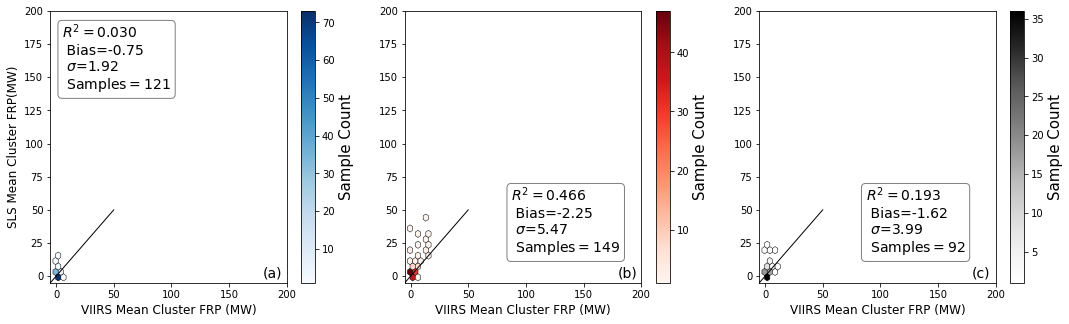

In [459]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

plt.close('all')
fig = plt.figure(figsize=(18, 5))
ax0 = plt.subplot(131)
ax1 = plt.subplot(132)
ax2 = plt.subplot(133)

h = ax0.hexbin(sls_vs_viirs_got.frp_viirs, sls_vs_viirs_got.frp_sls, gridsize=45, mincnt=1,
          cmap='Blues', linewidths=0.5, edgecolors='k',extent=[-5, 200, -5, 200])
cbar = plt.colorbar(mappable=h, ax=ax0).set_label('Sample Count', fontsize=15)

h = ax1.hexbin(sls_vs_viirs_libya.frp_viirs, sls_vs_viirs_libya.frp_sls, gridsize=45, mincnt=1,
          cmap='Reds', linewidths=0.5, edgecolors='k', extent=[-5, 200, -5, 200])
cbar = plt.colorbar(mappable=h, ax=ax1).set_label('Sample Count', fontsize=15)

h = ax2.hexbin(sls_vs_viirs_niger_delta.frp_viirs, sls_vs_viirs_niger_delta.frp_sls, gridsize=45, mincnt=1,
          cmap='Greys', linewidths=0.5, edgecolors='k', extent=[-5, 200, -5, 200])
cbar = plt.colorbar(mappable=h, ax=ax2).set_label('Sample Count', fontsize=15)

# sns.regplot(ats_vs_viirs.frp_viirs, ats_vs_viirs.frp_ats, ci=95, color='k', ax=ax0, scatter=False)
# sns.regplot(sls_vs_viirs.frp_viirs, sls_vs_viirs.frp_sls, ci=95, color='k', ax=ax1, scatter=False)

ax0.text(0.90, 0.02, '(a)', transform=ax0.transAxes, fontsize=14)
ax1.text(0.90, 0.02, '(b)', transform=ax1.transAxes, fontsize=14)
ax2.text(0.90, 0.02, '(c)', transform=ax2.transAxes, fontsize=14)


x_lim = (-5,50)
y_lim = (-5,50)
ax0.plot(x_lim, y_lim, color='k', linestyle='-', linewidth=1)
ax1.plot(x_lim, y_lim, color='k', linestyle='-', linewidth=1)
ax2.plot(x_lim, y_lim, color='k', linestyle='-', linewidth=1)


# ax0.set_xlim(x_lim)
# ax1.set_xlim(x_lim)

# ax0.set_ylim(y_lim)
# ax1.set_ylim(y_lim)

ax0.set(ylabel='SLS Mean Cluster FRP(MW)', xlabel='VIIRS Mean Cluster FRP (MW)')
ax0.yaxis.label.set_size(12)
ax0.xaxis.label.set_size(12)

ax1.set(xlabel='VIIRS Mean Cluster FRP (MW)')
ax1.xaxis.label.set_size(12)

ax2.set(xlabel='VIIRS Mean Cluster FRP (MW)')
ax2.xaxis.label.set_size(12)

slope0, intercept0, r_value0, _, _ = scipy.stats.linregress(sls_vs_viirs_got.frp_viirs, 
                                                            sls_vs_viirs_got.frp_sls)
slope1, intercept1, r_value1, _, _ = scipy.stats.linregress(sls_vs_viirs_libya.frp_viirs, 
                                                            sls_vs_viirs_libya.frp_sls)
slope2, intercept2, r_value2, _, _ = scipy.stats.linregress(sls_vs_viirs_niger_delta.frp_viirs, 
                                                            sls_vs_viirs_niger_delta.frp_sls)

# zero intercept reg
# x = sls_vs_viirs.frp_viirs.values[:,np.newaxis]
# y = sls_vs_viirs.frp_sls.values
# a, _, _, _ = np.linalg.lstsq(x, y)


got_median = np.median(sls_vs_viirs_got.frp_viirs - sls_vs_viirs_got.frp_sls)
libya_median = np.median(sls_vs_viirs_libya.frp_viirs - sls_vs_viirs_libya.frp_sls)
niger_delta_median = np.median(sls_vs_viirs_niger_delta.frp_viirs - sls_vs_viirs_niger_delta.frp_sls)

print 'got median:', got_median
print 'libya median:', libya_median
print 'niger median:', niger_delta_median

got_mean = np.mean(sls_vs_viirs_got.frp_viirs - sls_vs_viirs_got.frp_sls)
libya_mean = np.mean(sls_vs_viirs_libya.frp_viirs - sls_vs_viirs_libya.frp_sls)
niger_delta_mean = np.mean(sls_vs_viirs_niger_delta.frp_viirs - sls_vs_viirs_niger_delta.frp_sls)

got_sd = np.std(sls_vs_viirs_got.frp_viirs - sls_vs_viirs_got.frp_sls)
libya_sd = np.std(sls_vs_viirs_libya.frp_viirs - sls_vs_viirs_libya.frp_sls)
niger_delta_sd = np.std(sls_vs_viirs_niger_delta.frp_viirs - sls_vs_viirs_niger_delta.frp_sls)

textstr0 = '$R^2=%.3f$\n Bias=%.2f\n $\sigma$=%.2f\n Samples$=%.0f$' % (r_value0**2, got_mean, got_sd, sls_vs_viirs_got.frp_viirs.shape[0])
textstr1 = '$R^2=%.3f$\n Bias=%.2f\n $\sigma$=%.2f\n Samples$=%.0f$' % (r_value1**2, libya_mean, libya_sd, sls_vs_viirs_libya.frp_viirs.shape[0]) 
textstr2 = '$R^2=%.3f$\n Bias=%.2f\n $\sigma$=%.2f\n Samples$=%.0f$' % (r_value2**2, niger_delta_mean, niger_delta_sd, sls_vs_viirs_niger_delta.frp_viirs.shape[0]) 


props = dict(boxstyle='round', facecolor='white', alpha=0.5)

ax0.text(0.05, 0.95, textstr0, transform=ax0.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax1.text(0.45, 0.35, textstr1, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax2.text(0.45, 0.35, textstr2, transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


#plt.savefig(os.path.join(output_path, 'viirs_vs_ats_iraq.png'), bbox_inches='tight', dpi=600)
plt.show()

# ------- COUNTRY LEVEL ANALYSES -------

First restrict slstr data to an annum.  Currently we have contiguous data from June 2017 through May 2018, so lets set this as the annum that we are using.  Think we can justify as it is the most up to date dataset and we are just doing it as a demonstration.  If not we get and process all the data, asking for it off CEMS

In [425]:
# adjust SLSTR FRP
sls_flare_df_annum.frp *= 0.89

# adjust SLSTR year
sls_flare_df_annum.loc[:, 'year'] = 2017
sls_flare_sampling_df_annum.loc[:, 'year'] = 2017

# ANNUAL TIMESERIES: ANNUAL ACTIVE FLARES
Ratio of the number of flares seen active in any given country over a 12 month period to all flares seen active in the given country over the entire timeseries (both ATS and SLS.

In [426]:
def counts_by_country(ats_flare_df, sls_flare_df, ats_countries_df, sls_countries_df):
    
    flare_df = pd.concat([ats_flare_df, sls_flare_df])
    countries_df = pd.concat([ats_countries_df, sls_countries_df])
    
    # rename years where we have data from both sensors (1996 AT1 & AT2; 2002 AT2 & ATS )    
    flare_df.sensor.loc[flare_df.year == 1996] = 'AT1 & AT2'
    flare_df.sensor.loc[flare_df.year == 2002] = 'AT2 & ATS'
    
    # get unique countries
    countries_df.drop_duplicates(['countries', 'lats_arcmin', 'lons_arcmin'], inplace=True)
    
    # get unique annual flares
    annual_unique_flares = flare_df.drop_duplicates(['lats_arcmin', 'lons_arcmin', 'year'])[['lats_arcmin', 'lons_arcmin', 'year']]    
    annual_unique_flares_by_sensor = flare_df.drop_duplicates(['lats_arcmin', 'lons_arcmin', 'year', 'sensor'])[['lats_arcmin', 'lons_arcmin', 'year', 'sensor']]
        
    # merge countries
    annual_unique_flares = annual_unique_flares.merge(countries_df[['countries', 'lats_arcmin', 'lons_arcmin']],  on=['lats_arcmin', 'lons_arcmin'])
    annual_unique_flares_by_sensor = annual_unique_flares_by_sensor.merge(countries_df[['countries', 'lats_arcmin', 'lons_arcmin']],  on=['lats_arcmin', 'lons_arcmin'])

    # add active flares and flare locations columns
    annual_unique_flares['active_flare_locations'] = 1
    annual_unique_flares_by_sensor['active_flare_locations'] = 1
    
    # now group 
    grouped_annual_unique_flares = annual_unique_flares.groupby(['year', 'countries'], as_index=False).agg(
        {'active_flare_locations': np.sum})
    grouped_annual_unique_flares_by_sensor = annual_unique_flares_by_sensor.groupby(['year', 'countries', 'sensor'], as_index=False).agg(
        {'active_flare_locations': np.sum})
    
    # divide by 1000 (to get counts in 000s)
    grouped_annual_unique_flares['active_flare_locations'] = grouped_annual_unique_flares.active_flare_locations /1000
    grouped_annual_unique_flares_by_sensor['active_flare_locations'] = grouped_annual_unique_flares_by_sensor.active_flare_locations /1000
    

    return grouped_annual_unique_flares, grouped_annual_unique_flares_by_sensor
    

In [427]:
annual_flare_activity_df, annual_flare_activity_by_sensor_df = counts_by_country(ats_flare_df, 
                                                                                 sls_flare_df_annum, 
                                                                                 ats_countries_df, 
                                                                                 sls_countries_df)


In [428]:
for yr in [1991, 2012]:
    annual_flare_activity_by_sensor_df = annual_flare_activity_by_sensor_df[annual_flare_activity_by_sensor_df.year != yr]

# get the global annual FRP values
global_activity = annual_flare_activity_by_sensor_df.groupby(['sensor', 'year'], as_index=False).agg({'active_flare_locations': np.sum})
global_activity = global_activity.pivot('year', 'sensor', 'active_flare_locations')
global_activity.columns.name = None
global_activity.rename(columns={'at1': 'AT1', 'at2':'AT2', 'ats':'ATS', 'sls':'SLS'}, inplace=True)
global_activity = global_activity[['AT1', 'AT1 & AT2', 'AT2', 'AT2 & ATS', 'ATS', 'SLS']]

to_group = ['countries', 'year']
to_agg = {'active_flare_locations': np.sum}
screened_countries_activity_df = annual_flare_activity_by_sensor_df.groupby(to_group, as_index=False).agg(to_agg)

# # find the top n flaring countries
n_countries = 30
top_flaring_countries = screened_countries_activity_df.groupby('countries').agg({'active_flare_locations': np.sum}).sort_values('active_flare_locations', ascending=False).head(n_countries).reset_index()

# # reduce to the top countries
top_country_activity = screened_countries_activity_df.merge(top_flaring_countries[['countries']],  on=['countries'])

# pivoted
pivoted_df = top_country_activity.pivot('year', 'countries', 'active_flare_locations')
df_list = []
for c in top_flaring_countries.countries.values:
    df_list.append(pivoted_df[c])
top_country_activity = pd.concat(df_list, axis=1)

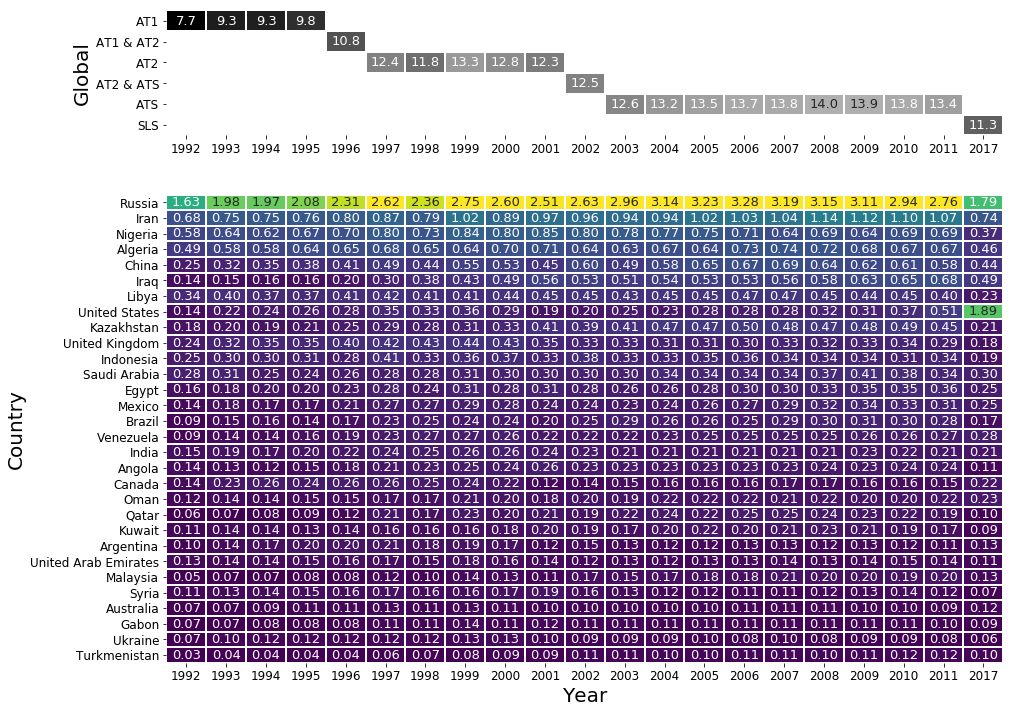

In [429]:
plt.close('all')
#fig, ax = plt.figure(figsize=(18,7))

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, 
                               gridspec_kw={'height_ratios': [2, 7.5]},
                               figsize=(15, 12))

sns.heatmap(global_activity.T, linewidths=1,
            robust=True, annot=True, 
            annot_kws={'fontsize':13},
            fmt='.1f',
            cbar=False,
            cmap='Greys_r',
            vmax=18,
            ax=ax0)

ax0.set(xlabel='', ylabel='Global')
ax0.yaxis.label.set_size(20)
ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=12)
ax0.set_yticklabels(ax0.get_yticklabels(), fontsize=12, rotation=0)

sns.heatmap(top_country_activity.T, linewidths=1,
            robust=True, annot=True, 
            annot_kws={'fontsize':13}, 
            fmt='.2f',
            cbar=False,
            cmap='viridis',
            ax=ax1)
ax1.set(xlabel='Year', ylabel='Country')
ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)
plt.savefig(os.path.join(output_path, 'ats_counts.png'), bbox_inches='tight', dpi=600)

plt.show()

Figure Comments: The global figure shows all counts for all sensors (exlcuding 2016 data for SLS as no flare observations).  The country level analysis uses only the valid non-overlapping years (which are defined in the code), so: AT2 1995; AT1 1996; ATS 2002; & AT2 2003 are not used).  This needs to be done, as the geospatial alginment is not exact and we cannot be certain on the total counts if we combine sensors (i.e. perhaps double counting some flares).

### Percent Change

In [430]:
activity_global_pc_change = annual_flare_activity_by_sensor_df.groupby(['sensor', 'year'], as_index=False).agg({'active_flare_locations': np.sum})
activity_global_pc_change = activity_global_pc_change.sort_values('year')
activity_global_pc_change['pc_change'] = (activity_global_pc_change.active_flare_locations / activity_global_pc_change.active_flare_locations.shift() - 1) 
activity_global_pc_change.drop('active_flare_locations', axis=1, inplace=True)
activity_global_pc_change = activity_global_pc_change.pivot('year', 'sensor', 'pc_change')
activity_global_pc_change.rename(columns={'at1': 'AT1', 'at2':'AT2', 'ats':'ATS', 'sls':'SLS'}, inplace=True)
activity_global_pc_change = activity_global_pc_change[['AT1', 'AT1 & AT2', 'AT2', 'AT2 & ATS', 'ATS', 'SLS']]


activity_country_pc_change = top_country_activity.copy()
activity_country_pc_change = (activity_country_pc_change / activity_country_pc_change.shift() - 1) 

for yr in [1992]:
    activity_global_pc_change = activity_global_pc_change[activity_global_pc_change.index != yr]
    activity_country_pc_change = activity_country_pc_change[activity_country_pc_change.index != yr]

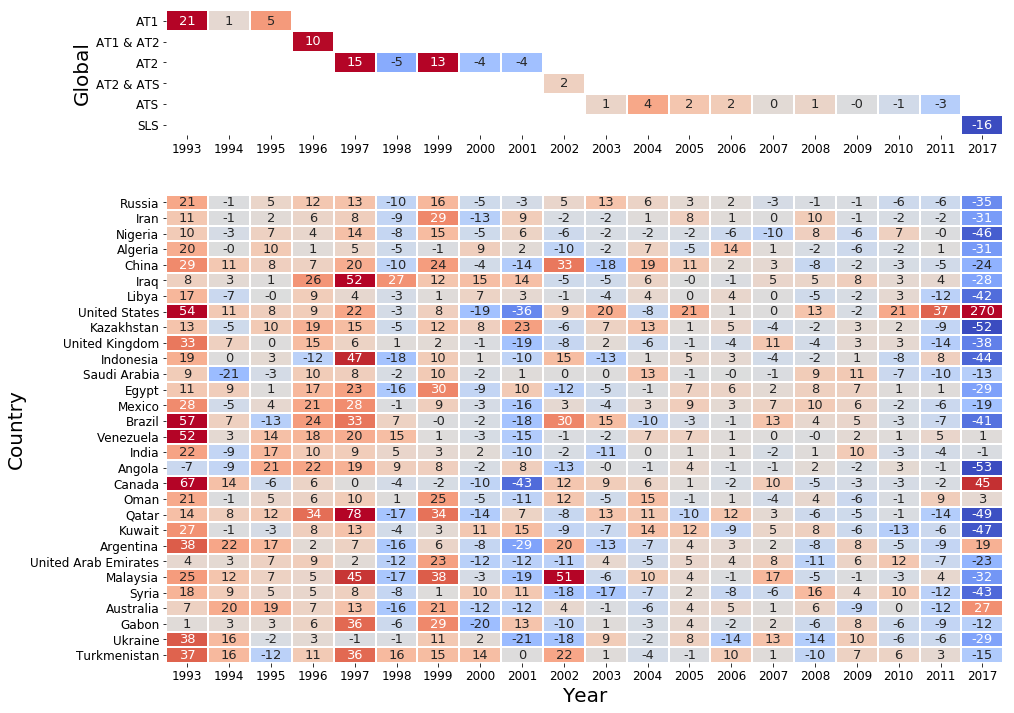

In [431]:
plt.close('all')
#fig, ax = plt.figure(figsize=(18,7))

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, 
                               gridspec_kw={'height_ratios': [2, 7.5]},
                               figsize=(15, 12))

sns.heatmap(activity_global_pc_change.T*100, linewidths=1,
            robust=True, annot=True, 
            fmt='.0f', annot_kws={'fontsize':13}, 
            cbar=False,
            cmap='coolwarm',
            vmax=10, vmin=-10,
            ax=ax0)

ax0.set(xlabel='', ylabel='Global')
ax0.yaxis.label.set_size(20)
ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=12)
ax0.set_yticklabels(ax0.get_yticklabels(), fontsize=12, rotation=0)


sns.heatmap(activity_country_pc_change.T*100, linewidths=1,
            robust=True, annot=True, 
            fmt='.0f', annot_kws={'fontsize':13}, 
            cbar=False,
            cmap='coolwarm',
            vmax=50, vmin=-50,
            ax=ax1)
ax1.set(xlabel='Year', ylabel='Country')
ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)

plt.savefig(os.path.join(output_path, 'ats_counts_change.png'), bbox_inches='tight', dpi=600)

plt.show()

# COMPUTE ANNUAL MEAN CLOUD ADJUSTED FRP PER COUNTRY
First group each arcminute grid cell for each year in the flare dataframe, aggregating the fire radiative power and the total number of observations in that year by summing.  Do the same for the sampling dataframe (i.e. the number of overpass for a given flare).

The cloud adjusted mean is computed as the sum of the hotspot's FRP for the year divided by the total number of overpasses for the hotspot adjusted for cloud cover e.g. 6000 [MW] / ( 120 [Obs.] * (1 - 0.6 [CC]).  So we in effect get the mean FRP based on some assumption of number of cloud free observations (this also normalises for variance in observation).  The cloud cover I estimate from an 8 by 8 window around each hotspot, from which I take the ATSR cloud flag.  This is then averaged for the year, so I get an annual mean cloud cover estimate for each hotspot.

what happens if the "hotspot" is observed to be not there? i.e. a location previously seen to be a flare is cloud free - but now there is nothing there (i.e. flare is turned off for a while...maybe it is re-detected in a few weeks or months?).  Do these "zero" FRP values contribute to the "mean FRP" or not?  it seems not from your calculation.  if they do not then multippying the cloud-adjusted Mean FRP by the number of secs in a year will not i think come up with "correct FRE" will it? Because you are then counting the thing has burning at its "mean FRP" value even when it has been observed as not burning? When there has been a cloud free observation of the flares location and it is confirmed that there is "nothing there" then that time period should not contribute to the FRE calculation..or...the "mean FRE" should include the value of "zero FRP" observed for that observation. 

The number of observations includes not only active flaring, but all overpasses of the flaring location during the year.  So in the above example the 6000MW could be calculated from 50 of the 120 overpasses, but all 120 (including the 70 'zero' observations) are used for the mean (although this number is further adjusted for cloud cover).  So it does take into account the issue of flare persistence. 

Two different dataframe are created.  One with sensor information and one without.  The one without sensor information effectively creates a mean value for any overlapping years.  This is unwanted, but useful in any analysis.  The one with sensor information allows screening of year/sensor combinations so that we don't get any overlapping information contaminating the results. 

In [432]:
def frp_by_country(flare_df, sampling_df, countries_df):
    
    # compute the annual mean for each flare
    to_group = ['lats_arcmin', 'lons_arcmin', 'year']
    to_agg = {'frp': np.sum,
              'sample_counts_flare': np.sum,
              'lats': np.mean,
              'lons': np.mean}
    annual_summed_flare_df = flare_df.groupby(to_group, as_index=False).agg(to_agg)
    
    # get the cloud cover adjusted sampling
    to_group = ['lats_arcmin', 'lons_arcmin', 'year']
    to_agg = {'cloud_cover': np.mean,
              'sample_counts_all': np.sum}
    annual_sample_df = sampling_df.groupby(to_group, as_index=False).agg(to_agg)
    
    print annual_sample_df.head()
    
    # merge and get cloud cloud adjusted sampling (i.e the expected number of observations)
    annual_frp_df = pd.merge(annual_summed_flare_df, annual_sample_df, on=to_group)
    annual_frp_df['cloud_adjusted_sample_counts'] = annual_frp_df.sample_counts_all * (1-annual_frp_df.cloud_cover)

    # if expected less than actual, then set to actual number of obsercations
    mask = annual_frp_df['cloud_adjusted_sample_counts'] < annual_frp_df['sample_counts_flare']
    annual_frp_df.loc[mask, 'cloud_adjusted_sample_counts'] = annual_frp_df.loc[mask, 'sample_counts_flare']

    # compute mean frp
    annual_frp_df['cloud_adjusted_mean_frp'] = annual_frp_df.frp / annual_frp_df.cloud_adjusted_sample_counts

    # merge countries
    annual_frp_df = annual_frp_df.merge(countries_df[['countries', 'lats_arcmin', 'lons_arcmin']],  on=['lats_arcmin', 'lons_arcmin'])

    # sum on a per country basis
    grouped_annual_frp = annual_frp_df.groupby(['year', 'countries'], as_index=False).agg({'cloud_adjusted_mean_frp': np.sum})

    # ---------------------------------------
    # Same again but with sensor information
    # ---------------------------------------
    
    # rename years where we have data from both sensors (1996 AT1 & AT2; 2002 AT2 & ATS )    
    flare_df.sensor.loc[flare_df.year == 1996] = 'AT1 & AT2'
    flare_df.sensor.loc[flare_df.year == 2002] = 'AT2 & ATS'
    sampling_df.sensor.loc[sampling_df.year == 1996] = 'AT1 & AT2'
    sampling_df.sensor.loc[sampling_df.year == 2002] = 'AT2 & ATS'
    
    # compute the annual mean for each flare
    to_group = ['lats_arcmin', 'lons_arcmin', 'year', 'sensor']
    to_agg = {'frp': np.sum,
              'sample_counts_flare': np.sum,
              'lats': np.mean,
              'lons': np.mean}
    annual_summed_flare_df = flare_df.groupby(to_group, as_index=False).agg(to_agg)
    
    # get the cloud cover adjusted sampling
    to_group = ['lats_arcmin', 'lons_arcmin', 'year', 'sensor']
    to_agg = {'cloud_cover': np.mean,
              'sample_counts_all': np.sum}
    annual_sample_df = sampling_df.groupby(to_group, as_index=False).agg(to_agg)
    
    # merge and get cloud cloud adjusted sampling (i.e the expected number of observations)
    annual_frp_df = pd.merge(annual_summed_flare_df, annual_sample_df, on=to_group)
    annual_frp_df['cloud_adjusted_sample_counts'] = annual_frp_df.sample_counts_all * (1-annual_frp_df.cloud_cover)

    # if expected less than actual, then set to actual number of obsercations
    mask = annual_frp_df['cloud_adjusted_sample_counts'] < annual_frp_df['sample_counts_flare']
    annual_frp_df.loc[mask, 'cloud_adjusted_sample_counts'] = annual_frp_df.loc[mask, 'sample_counts_flare']

    # compute mean frp
    annual_frp_df['cloud_adjusted_mean_frp'] = annual_frp_df.frp / annual_frp_df.cloud_adjusted_sample_counts

    # merge countries
    annual_frp_df = annual_frp_df.merge(countries_df[['countries', 'lats_arcmin', 'lons_arcmin']],  on=['lats_arcmin', 'lons_arcmin'])

    # sum on a per country basis
    grouped_annual_frp_by_sensor = annual_frp_df.groupby(['year', 'countries', 'sensor'], as_index=False).agg({'cloud_adjusted_mean_frp': np.sum})
    
    return grouped_annual_frp, grouped_annual_frp_by_sensor

In [433]:
ats_annual_frp_by_country, ats_annual_frp_by_country_with_sensor = frp_by_country(ats_flare_df, 
                                                                                 ats_flare_sampling_df, 
                                                                                 ats_countries_df)
sls_annual_frp_by_country, sls_annual_frp_by_country_wtih_sensor = frp_by_country(sls_flare_df_annum, 
                                                                                  sls_flare_sampling_df_annum,
                                                                                  sls_countries_df)


   lats_arcmin  lons_arcmin    year  cloud_cover  sample_counts_all
0      -5355.0      -6751.0  1991.0     0.632766                 34
1      -5355.0      -6751.0  1992.0     0.632766                 96
2      -5355.0      -6751.0  1993.0     0.632766                113
3      -5355.0      -6751.0  1994.0     0.632766                107
4      -5355.0      -6751.0  1995.0     0.632766                 95
   lats_arcmin  lons_arcmin  year  cloud_cover  sample_counts_all
0      -5353.0      -6738.0  2017     0.722643                222
1      -5340.0      -6758.0  2017     0.653948                228
2      -5322.0      -6809.0  2017     0.694180                238
3      -5321.0      -6809.0  2017     0.694180                238
4      -5319.0      -6811.0  2017     0.701499                238


In [434]:
ats_annual_frp_by_country_with_sensor.sensor.unique()

array(['at1', 'AT1 & AT2', 'at2', 'AT2 & ATS', 'ats'], dtype=object)

# DMSP ANNUAL NATIONAL FLARED VOLUME COMPARISON WITH ATSR

In [435]:
df_with_bcm = ats_annual_frp_by_country_with_sensor.copy()

df_with_bcm = ats_annual_frp_by_country.merge(bcm_df, on=['countries', 'year'])
df_with_bcm.dropna(inplace=True)

# get rid of end years
df_with_bcm = df_with_bcm[df_with_bcm.year != 2012]
df_with_bcm = df_with_bcm[df_with_bcm.year != 1991]

# russia and nigeria
df_with_bcm_rn = df_with_bcm.copy()
df_with_bcm_rn = df_with_bcm_rn[(df_with_bcm_rn.countries == 'Russia') | 
                                (df_with_bcm_rn.countries == 'Nigeria')]

# all other countires
df_with_bcm_not_rn = df_with_bcm.copy()
df_with_bcm_not_rn = df_with_bcm_not_rn[(df_with_bcm_not_rn.countries != 'Russia') & 
                                (df_with_bcm_not_rn.countries != 'Nigeria')]


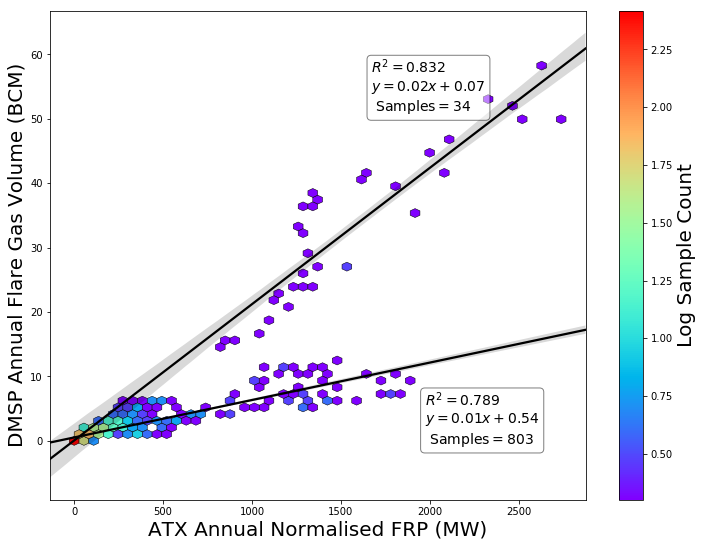

In [436]:
plt.close('all')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9))

h = ax.hexbin(df_with_bcm.cloud_adjusted_mean_frp, df_with_bcm.bcm, gridsize=50, bins='log', mincnt=1,
          cmap='rainbow', linewidths=0.5, edgecolors='k')
cbar = plt.colorbar(mappable=h).set_label('Log Sample Count', fontsize=20)

sns.regplot(df_with_bcm_rn.cloud_adjusted_mean_frp, df_with_bcm_rn.bcm, ci=68, color='k', ax=ax, scatter=False)
sns.regplot(df_with_bcm_not_rn.cloud_adjusted_mean_frp, df_with_bcm_not_rn.bcm, ci=68, color='k', ax=ax, scatter=False)

ax.set(ylabel='DMSP Annual Flare Gas Volume (BCM)', xlabel='ATX Annual Normalised FRP (MW)')
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

slope0, intercept0, r_value0, _, _ = scipy.stats.linregress(df_with_bcm_rn.cloud_adjusted_mean_frp, 
                                                            df_with_bcm_rn.bcm)
slope1, intercept1, r_value1, _, _ = scipy.stats.linregress(df_with_bcm_not_rn.cloud_adjusted_mean_frp, 
                                                            df_with_bcm_not_rn.bcm)


textstr0 = '$R^2=%.3f$\n$y=%.2fx + %.2f$\n Samples$=%.0f$' % (r_value0**2, slope0, intercept0, df_with_bcm_rn.bcm.shape[0])
textstr1 = '$R^2=%.3f$\n$y=%.2fx + %.2f$\n Samples$=%.0f$' % (r_value1**2, slope1, intercept1, df_with_bcm_not_rn.bcm.shape[0]) 

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

ax.text(0.6, 0.9, textstr0, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(0.7, 0.22, textstr1, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.savefig(os.path.join(output_path, 'dmsp_vs_ats.png'), bbox_inches='tight', dpi=600)

plt.show()

# ANNUAL TIMESERIES: COUNTRY LEVEL SUMMED MEAN FLARE FRP 
Each flare has its annual mean computed and then all flares for a given nation are summed together for the year

In [437]:
# reduce the data to only complete years
ats_with_sensor_df = ats_annual_frp_by_country_with_sensor.copy()
sls_with_sensor_df = sls_annual_frp_by_country_wtih_sensor.copy()

for yr in [1991, 2012, 2016]:
    ats_with_sensor_df = ats_with_sensor_df[ats_with_sensor_df.year != yr]
    sls_with_sensor_df = sls_with_sensor_df[sls_with_sensor_df.year != yr]

# combine the dataframes
combined_with_sensor_df = pd.concat([ats_with_sensor_df, sls_with_sensor_df])
    
# get the global annual FRP values
global_frp = combined_with_sensor_df.groupby(['sensor', 'year'], as_index=False).agg({'cloud_adjusted_mean_frp': np.sum})
global_frp.cloud_adjusted_mean_frp /= 1000  # why this?  Conversion to MW 
global_frp = global_frp.pivot('year', 'sensor', 'cloud_adjusted_mean_frp')
global_frp.columns.name = None
global_frp.rename(columns={'at1': 'AT1', 'at2':'AT2', 'ats':'ATS', 'sls':'SLS'}, inplace=True)
global_frp = global_frp[['AT1', 'AT1 & AT2', 'AT2', 'AT2 & ATS', 'ATS', 'SLS']]
    
# now aggregate to remove sensor information from screened data 
to_group = ['countries', 'year']
to_agg = {'cloud_adjusted_mean_frp': np.sum}
combined_df = combined_with_sensor_df.groupby(to_group, as_index=False).agg(to_agg)
combined_df.cloud_adjusted_mean_frp /= 1000

# # find the top n flaring countries
n_countries = 30
top_flaring_countries = combined_df.groupby('countries').agg({'cloud_adjusted_mean_frp': np.sum}).sort_values('cloud_adjusted_mean_frp', ascending=False).head(n_countries).reset_index()

# # reduce to the top countries
top_flaring_activity = combined_df.merge(top_flaring_countries[['countries']],  on=['countries'])

# pivoted
pivoted_df = top_flaring_activity.pivot('year', 'countries', 'cloud_adjusted_mean_frp')
df_list = []
for c in top_flaring_countries.countries.values:
    df_list.append(pivoted_df[c])
top_flaring_activity = pd.concat(df_list, axis=1)

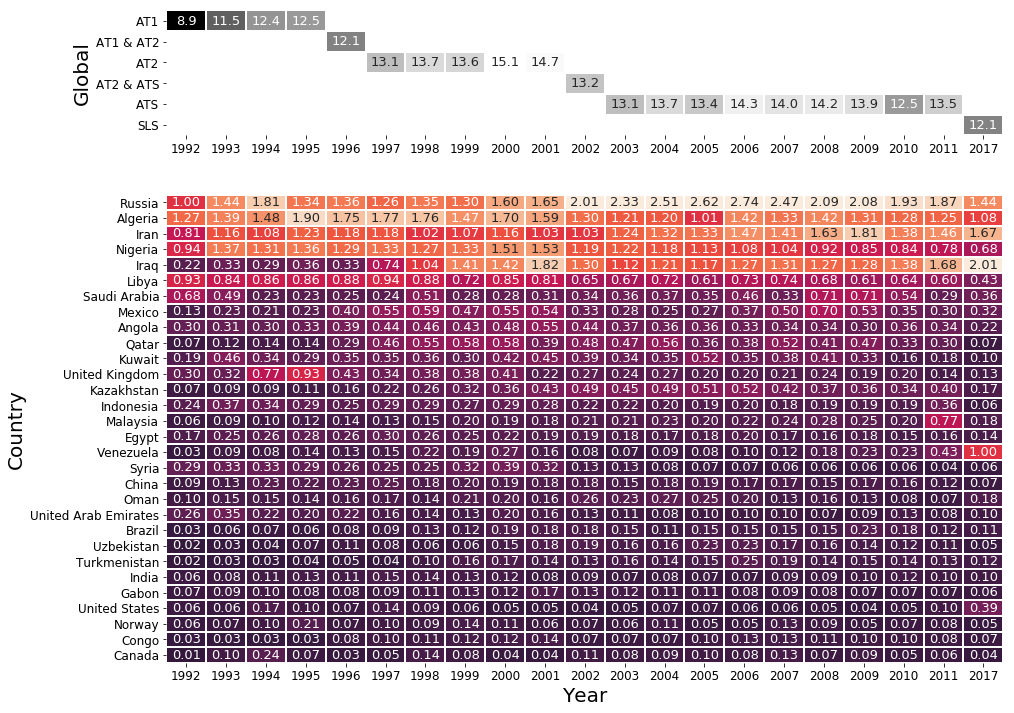

In [438]:
plt.close('all')
#fig, ax = plt.figure(figsize=(18,7))

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, 
                               gridspec_kw={'height_ratios': [2, 7.5]},
                               figsize=(15, 12))

sns.heatmap(global_frp.T, linewidths=1,
            robust=True, annot=True, 
            fmt='.1f', annot_kws={'fontsize':13}, 
            cbar=False,
            cmap='Greys_r',
            ax=ax0)

ax0.set(xlabel='', ylabel='Global')
ax0.yaxis.label.set_size(20)
ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=12)
ax0.set_yticklabels(ax0.get_yticklabels(), fontsize=12, rotation=0)


sns.heatmap(top_flaring_activity.T, linewidths=1,
            robust=True, annot=True, 
            fmt='.2f', annot_kws={'fontsize':13}, 
            cbar=False,
            vmin=-0.3, vmax=2,
            ax=ax1)
ax1.set(xlabel='Year', ylabel='Country')
ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)
plt.savefig(os.path.join(output_path, 'ats_frp.png'), bbox_inches='tight', dpi=600)

plt.show()

### Percent Change

In [439]:
frp_global_pc_change = combined_with_sensor_df.groupby(['sensor', 'year'], as_index=False).agg({'cloud_adjusted_mean_frp': np.sum})
frp_global_pc_change = frp_global_pc_change.sort_values('year')
frp_global_pc_change['pc_change'] = (frp_global_pc_change.cloud_adjusted_mean_frp / frp_global_pc_change.cloud_adjusted_mean_frp.shift() - 1) 
frp_global_pc_change.drop('cloud_adjusted_mean_frp', axis=1, inplace=True)
frp_global_pc_change = frp_global_pc_change.pivot('year', 'sensor', 'pc_change')
frp_global_pc_change.rename(columns={'at1': 'AT1', 'at2':'AT2', 'ats':'ATS', 'sls':'SLS'}, inplace=True)
frp_global_pc_change = frp_global_pc_change[['AT1', 'AT1 & AT2', 'AT2', 'AT2 & ATS', 'ATS', 'SLS']]


frp_country_pc_change = (top_flaring_activity / top_flaring_activity.shift() - 1) 
for yr in [1992]:
    frp_global_pc_change = frp_global_pc_change[frp_global_pc_change.index != yr]
    frp_country_pc_change = frp_country_pc_change[frp_country_pc_change.index != yr]

In [440]:
#frp_global_pc_change = frp_global_pc_change[frp_global_pc_change.index >= 2003]
#frp_global_pc_change = frp_global_pc_change.T[(frp_global_pc_change.T.index == u'ATS') |
#                                              (frp_global_pc_change.T.index == u'SLS')].T

#frp_country_pc_change = frp_country_pc_change[frp_country_pc_change.index >= 2003]

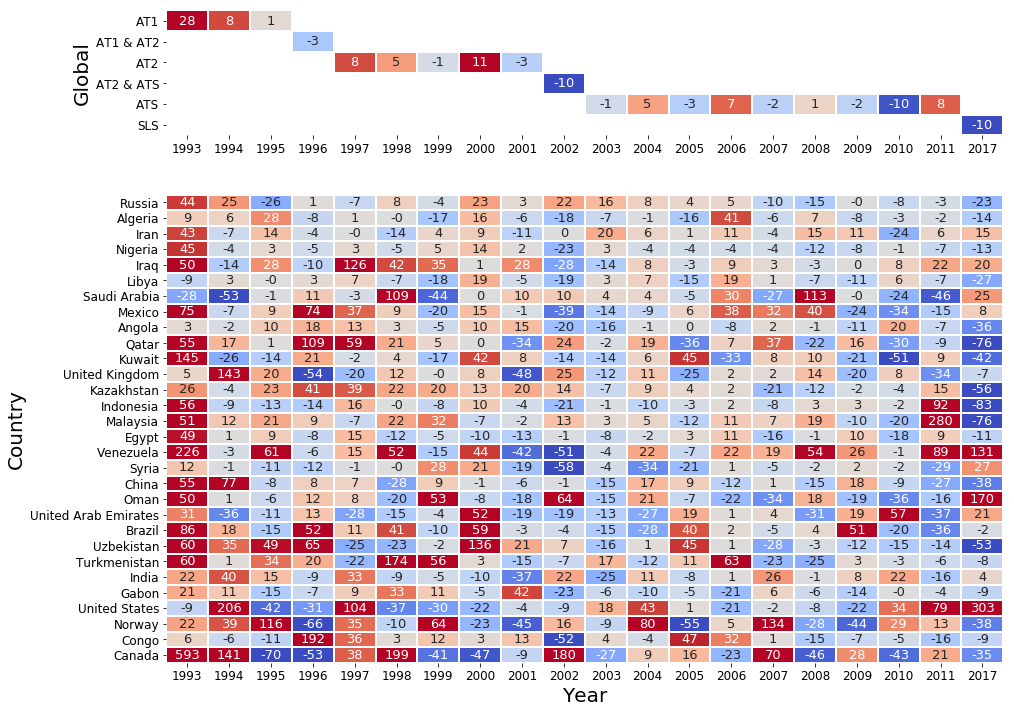

In [441]:
plt.close('all')
#fig, ax = plt.figure(figsize=(18,7))

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, 
                               gridspec_kw={'height_ratios': [2, 7.5]},
                               figsize=(15, 12))

sns.heatmap(frp_global_pc_change.T*100, linewidths=1,
            robust=True, annot=True, 
            fmt='.0f', annot_kws={'fontsize':13}, 
            cbar=False,
            cmap='coolwarm',
            vmax=10, vmin=-10,
            ax=ax0)

ax0.set(xlabel='', ylabel='Global')
ax0.yaxis.label.set_size(20)
ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=12)
ax0.set_yticklabels(ax0.get_yticklabels(), fontsize=12, rotation=0)


sns.heatmap(frp_country_pc_change.T*100, linewidths=1,
            robust=True, annot=True, 
            fmt='.0f', annot_kws={'fontsize':13}, 
            cbar=False,
            cmap='coolwarm',
            vmax=50, vmin=-50,
            ax=ax1)
ax1.set(xlabel='Year', ylabel='Country')
ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)
plt.savefig(os.path.join(output_path, 'ats_frp_change.png'), bbox_inches='tight', dpi=600)

plt.show()

# Analysis of Exceptional Countries

Correlation between FRP and Flare count for top countries over time series

In [ ]:
top_flaring_activity.T.reset_index().head()

## Venezuela
Flaring count stays about the same, but we see a massibe increase in flaring activity since 2011

In [ ]:
sls_countries_df.head()

In [ ]:
# first restrict to only flares in venezuala
vz_loc_df_sls = sls_countries_df.loc[sls_countries_df.countries == 'Venezuela',:]
#vz_df_ats = ats_countries_df

# get venezuela flares
venezuela_flare_df_sls = sls_flare_df_annum.merge(vz_loc_df_sls[['countries', 'lats_arcmin', 'lons_arcmin']],  on=['lats_arcmin', 'lons_arcmin'])
venezuela_sampling_df_sls = sls_flare_sampling_df_annum.merge(vz_loc_df_sls[['countries', 'lats_arcmin', 'lons_arcmin']],  on=['lats_arcmin', 'lons_arcmin'])

# compute the annual mean for each flare
to_group = ['lats_arcmin', 'lons_arcmin', 'year']
to_agg = {'frp': np.sum,
          'sample_counts_flare': np.sum,
          'lats': np.mean,
          'lons': np.mean}
venezuela_flare_df_sls = venezuela_flare_df_sls.groupby(to_group, as_index=False).agg(to_agg)

# get the cloud cover adjusted sampling
to_group = ['lats_arcmin', 'lons_arcmin', 'year']
to_agg = {'cloud_cover': np.mean,
          'sample_counts_all': np.sum}
venezuela_sampling_df_sls = venezuela_sampling_df_sls.groupby(to_group, as_index=False).agg(to_agg)

# merge and get cloud cloud adjusted sampling (i.e the expected number of observations)
venezuela_frp_df_sls = pd.merge(venezuela_flare_df_sls, venezuela_sampling_df_sls, on=to_group)
venezuela_frp_df_sls['cloud_adjusted_sample_counts'] = venezuela_frp_df_sls.sample_counts_all * (1-venezuela_frp_df_sls.cloud_cover)

# if expected less than actual, then set to actual number of obsercations
mask = venezuela_frp_df_sls['cloud_adjusted_sample_counts'] < venezuela_frp_df_sls['sample_counts_flare']
venezuela_frp_df_sls.loc[mask, 'cloud_adjusted_sample_counts'] = venezuela_frp_df_sls.loc[mask, 'sample_counts_flare']

# compute mean frp
venezuela_frp_df_sls['cloud_adjusted_mean_frp'] = venezuela_frp_df_sls.frp / venezuela_frp_df_sls.cloud_adjusted_sample_counts



In [ ]:
venezuela_frp_df_sls.tail()

# Total Flare Emission Map

This map shows each flares emissions over the entire ATSR timeseries.  We use the screened data (from the screening process above) and the FRP is the cloud adjusted values.  So it takes into account the persistency and typical cloud cover of the flare when computing the average.

This is currently showing the mean over the lifetime.  Change it to back to mean over year, multiply by time in year, then group over years to get flare activity.

In [ ]:
def myround(x, base=0.5):
    return base * np.round(x/base)

def plot_total_frp(frp, binned_stat, top_flares):
    plt.close('all')
    fig = plt.figure(figsize=(20,9))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_xlim(( -180, 180))
    ax.set_ylim((-90, 90))
    ax.coastlines(color='white', linewidth=0.75)
    
    img_extent = (-180, 180, -90, 90)
    ax.imshow(np.tile(np.array([[[0,0,0]]], 
          dtype=np.uint8), [2, 2, 1]),
      origin='upper',
      transform=ccrs.PlateCarree(),
      extent=img_extent)
    


    #ax.text(0.94, 0.92, lab, transform=ax.transAxes, fontsize=25, color='w')
    
    
    scat = ax.scatter(frp_df.lons, frp_df.lats,
              s=0.05,
              color='cyan',
              alpha=0.2,
              label='Flare Locations') 
    
    scat2 = ax.scatter(top_flares.lons, top_flares.lats,
                       s=55,
                       facecolor='chartreuse',
                       edgecolor='k',
                       alpha=1,
                       label='10% Flare Locations')   
    
    leg0 = ax.legend(loc = 3, scatterpoints = 1, prop={'size': 15,})
    leg0.get_frame().set_facecolor('k')
    leg0.legendHandles[0]._sizes = [40]
    leg0.legendHandles[0].set_alpha(1)
    
    leg0.legendHandles[1]._sizes = [110]
    leg0.legendHandles[1].set_alpha(1)
    
    plt.setp(leg0.get_texts(), color='w')

    im = ax.imshow(binned_stat, origin='upper', cmap='inferno', norm=LogNorm(vmin=10, vmax=10000), alpha=1,
              extent=img_extent, transform=ccrs.PlateCarree())
    cbar = plt.colorbar(mappable=im).set_label('Log FRP (MW)', fontsize=20)
    

    #-------------------
    # SUBPLOTS
    #-------------------
    
    # set up the subaxes and locations
    sub_x_extent = [(46, 53), (5,25), (4.5, 13.5)]
    sub_y_extent = [(25, 33), (27,33), (-9, 7)]
    rects = [[0.43, 0.2, 0.3, 0.25], [0.27, 0.68, 0.15, 0.2], [-0.12, 0.27, 0.6, 0.4]]
    locs = [(1,2), (3,4), (1,4)]

    # add in zoomed plots for rois
    for sub_x, sub_y, rect, loc in zip(sub_x_extent, sub_y_extent, rects, locs):
    
        sub_ax = fig.add_axes(rect,
                              projection=ccrs.PlateCarree(), )
        sub_ax.set_xlim(sub_x)
        sub_ax.set_ylim(sub_y)
        sub_ax.outline_patch.set_edgecolor('white')

        # show inset loc
        mark_inset(ax, sub_ax, loc1=loc[0], loc2=loc[1], fc="none", lw=1, ec='w')

        # add background
        #sub_ax.coastlines(color='white', linewidth=0.75)
        country_boundaries = feature.NaturalEarthFeature(category='cultural',
                                                name='admin_0_countries',
                                                scale='10m', facecolor='none')
        sub_ax.add_feature(country_boundaries, edgecolor='white')
        sub_ax.imshow(np.tile(np.array([[[0,0,0]]], 
              dtype=np.uint8), [2, 2, 1]),
          origin='upper',
          transform=ccrs.PlateCarree(),
          extent=sub_x + sub_y)

        sub_scat = sub_ax.scatter(frp_df.lons, frp_df.lats,
              s=0.05,
              color='cyan',
              alpha=0.2) 

        sub_scat2 = sub_ax.scatter(top_flares.lons, top_flares.lats,
                           s=55,
                           facecolor='chartreuse',
                           edgecolor='k',
                           alpha=1) 
    plt.savefig(os.path.join(output_path, 'flare_map.png'), bbox_inches='tight', dpi=600)
    plt.show()
                  

In [ ]:
# compute the annual mean for each flare
to_group = ['lats_arcmin', 'lons_arcmin', 'year']
to_agg = {'frp': np.sum,
          'sample_counts_flare': np.sum,
          'lats': np.mean,
          'lons': np.mean}
summed_flare_df = ats_flare_df.groupby(to_group, as_index=False).agg(to_agg)

# get the cloud cover adjusted sampling
to_group = ['lats_arcmin', 'lons_arcmin', 'year']
to_agg = {'cloud_cover': np.mean,
          'sample_counts_all': np.sum}
summed_sample_df = ats_flare_sampling_df.groupby(to_group, as_index=False).agg(to_agg)

# merge and get cloud cloud adjusted sampling (i.e the expected number of observations)
frp_df = pd.merge(summed_flare_df, summed_sample_df, on=to_group)
frp_df['cloud_adjusted_sample_counts'] = frp_df.sample_counts_all * (1-frp_df.cloud_cover)

# if expected less than actual, then set to actual number of obsercations
mask = frp_df['cloud_adjusted_sample_counts'] < frp_df['sample_counts_flare']
frp_df.loc[mask, 'cloud_adjusted_sample_counts'] = frp_df.loc[mask, 'sample_counts_flare']

# compute mean frp
frp_df['cloud_adjusted_mean_frp'] = frp_df.frp / frp_df.cloud_adjusted_sample_counts

# get yearly sums
to_group = ['lats_arcmin', 'lons_arcmin']
to_agg = {'cloud_adjusted_mean_frp': np.sum, 'lats': np.mean, 'lons': np.mean}
annual_grouped_df = frp_df.groupby(to_group, as_index=False).agg(to_agg)



In [ ]:
bin_x = np.arange(-180, 185, 5)
bin_y = np.arange(-90, 95, 5)
binned_data = stats.binned_statistic_2d(annual_grouped_df.lons, annual_grouped_df.lats, 
                                        annual_grouped_df.cloud_adjusted_mean_frp, 'sum',
                                        bins=[bin_x, bin_y])
binned_stat = np.ma.masked_array(binned_data.statistic, binned_data.statistic==0)

### now get top flares for plotting

In [ ]:
annual_grouped_df['frp_pc_total'] =  annual_grouped_df.cloud_adjusted_mean_frp / annual_grouped_df.cloud_adjusted_mean_frp.sum()

In [ ]:
sorted_annual_grouped_df = annual_grouped_df.sort_values('frp_pc_total', ascending=False)
sorted_annual_grouped_df['frp_pc_cumsum'] = sorted_annual_grouped_df.frp_pc_total.cumsum()
sorted_annual_grouped_df.reset_index(inplace=True, drop=True)

In [ ]:
n_flares_10_pc = np.sum(sorted_annual_grouped_df.frp_pc_cumsum<0.1)
print n_flares_10_pc
n_flares_50_pc = np.sum(sorted_annual_grouped_df.frp_pc_cumsum<0.5)
print n_flares_50_pc
n_flares_90_pc = np.sum(sorted_annual_grouped_df.frp_pc_cumsum<0.9)
print n_flares_90_pc

In [ ]:
plt.close('all')
plt.figure(figsize=(9,9))
plt.plot(np.arange(sorted_annual_grouped_df.shape[0]), sorted_annual_grouped_df.frp_pc_total.cumsum(), 'k--',
         linewidth=1, label='Cumulative Percentage')
plt.plot([n_flares_10_pc, n_flares_10_pc], [-0.1, 0.1], 'k-', linewidth=0.5, label='10% (88 Flares)')
plt.plot([-1000, n_flares_10_pc], [0.1, 0.1], 'k-', linewidth=1)

plt.plot([n_flares_50_pc, n_flares_50_pc], [-0.1, 0.5], 'r-', linewidth=0.5, label='50% (1311 Flares)')
plt.plot([-1000, n_flares_50_pc], [0.5, 0.5], 'r-', linewidth=1)


plt.plot([n_flares_90_pc, n_flares_90_pc], [-0.1, 0.9], 'b-', linewidth=0.5, label='90% (7868 Flares)')
plt.plot([-1000, n_flares_90_pc], [0.9, 0.9], 'b-', linewidth=1)

plt.legend(loc=4,prop={'size': 12,})
plt.ylim(-0, 1)
plt.xlim(-750, 21000)
plt.savefig(os.path.join(output_path, 'ats_cumulative_frp.png'), bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
plot_total_frp(annual_grouped_df, np.flipud(binned_stat.T), 
               sorted_annual_grouped_df[sorted_annual_grouped_df.frp_pc_cumsum<0.1])

# ----------- NOTES -----------

Notes: 
* AT1 deficiences in Nighttime cloud masking due to only 11 & 12 um channels (so ineffective cloud masking) this means that we cannot trust the cloud adjusted FRP.  For ATSR flares, we instead use the cloud statistics for each flare from AT2 or ATS if available (with the assumption that cloud behaviour is generally consistent over any given year) 
* AT1 Data until May 1996 
* AT2 scan mirror failed  December 1995 to July 1996 (• ATSR-1 data available during this period except June 1996)
* ERS-2 Gyro failure in January 2001 (Months since gyro failure that are currently available: July to December
2001, July-August 2002, Jan-June 2003)
http://earth.esa.int/workshops/meris_aatsr2008/participants/616/pres_616_Veal.pdf

* ATSR-1	ERS-1	Jul 1991	
* ATSR-2	ERS-2	Apr 1995
* AATSR	  ENVISAT	Mar 2002	

TODO:
* Replace ATSR cloud fraction for each flare with that from ATSR-2 or AATSR
* Figure out cause of sampling differences between the three sensors (plot sampling)
* Sort out mixed years (1996: Jan-May AT1, Jul-Dec AT2; 2002: Jan-Mar AT2 Apr-Dec ATS)  DONE


https://earth.esa.int/pi/esa?topSelectedNavigationNodeId=RESULTS&colorTheme=03&type=upload&ts=1483208834953&table=result&targetIFramePage=%2Fweb%2Fguest%2Fpi-community%2Fresults&cmd=image&id=2780
See here for instrument coverage

In [ ]:
52*30